In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import warnings 
warnings.filterwarnings("ignore")

In [2]:
# AnnData object key
# odata - original anndata object containing all strains and circuit genes
# adata - contains genomically integrated strains and circuit genes
# bdata - contains genomically integrated strains without circuit genes
# obdata - contains all strains without circuit genes

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.signal import savgol_filter as sg
from scipy.io import loadmat
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size':23}); plt.rcParams.update({'axes.linewidth':2}); plt.rc('axes', axisbelow=True);
plt.rc('lines',linewidth=3); plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 
plt.rcParams['xtick.major.size'] = 8; plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 2; plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 8; plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 2; plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
# plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
# plt.rcParams['axes.xmargin'] = 0
# plt.rcParams['axes.ymargin'] = 0
figDir = '/Users/aqib/Desktop/BCCL/char-syn-gene-nets/MSB_submission/figures/'

import seaborn as sns
import time
import scanpy as sc
import anndata as ad
from copy import deepcopy
from collections import Counter
import re
import json
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from itertools import combinations
from random import choices

In [4]:
def concat_metadata2tpmdata(dftpm,dfmd):
    # add the metadata to the tpm data

    # find the rows of the metadata which correspond to the columns of the tpm data
    metalist = list(dfmd['sample_id'])
    dfmd_match_rowInd = []
    dftpm_match_colInd = []
    sid_count = 1
    for sid in dftpm.iloc[:,1:]:
        dfmd_match_rowInd.append(metalist.index(sid))
        dftpm_match_colInd.append(sid_count)
        sid_count = sid_count + 1
    # dfmd.iloc[dfmd_match_rowInd,:]

    # rename the row indices with the gene names
    dftpm_geneindex = dftpm.set_index('gene_id')
    dftpm_geneindex.index.names = [None]
    # dftpm_geneindex

    # create a dataframe, md2append, which contains just the metadata that correponds to the experiments in tpm data
    sids = list(dftpm_geneindex.columns)
    md2append = dfmd.T.iloc[:,dfmd_match_rowInd]
    md2append.columns = sids

    # concatenate the metadata to the top of the columns of tpm data
    dftpm_final = pd.concat([md2append,dftpm_geneindex[:]])
    # dftpm_final
    
    return(dftpm_final)

### Load data and metadata

In [5]:
df_tpm1 = pd.read_csv('ReadCountMatrix_preCAD_TPM_NANDiterate_1.tsv', sep='\t') # replicates 1,2,3,4 if they exist
df_tpm2 = pd.read_csv('ReadCountMatrix_preCAD_TPM_NANDiterate_2.tsv', sep='\t') # replicates 5,6,7,8 if they exist
df_metadata = pd.read_csv('NANDiterate_metadata.csv', sep=',')

In [6]:
df_tpm1_final = concat_metadata2tpmdata(df_tpm1,df_metadata)
df_tpm2_final = concat_metadata2tpmdata(df_tpm2,df_metadata)
df_tpm_final = pd.concat([df_tpm1_final,df_tpm2_final],axis=1)

### Remove samples with NaN values

In [7]:
sample_inds_with_nans = list(set(np.where(np.isnan(np.array(df_tpm_final.iloc[10:,:],dtype=np.float32)))[1]))
sample_with_nans = list(df_tpm_final.columns)[sample_inds_with_nans[0]]
df_tpm_final = df_tpm_final.drop(columns=[sample_with_nans],axis=1)

### Generate AnnData object 

In [8]:
obs_df = df_tpm_final.T.loc[:,['sample_id','timepoint','strain','temperature','replicate',
                               'arabinose_concentration','arabinose_unit','IPTG_concentration',
                               'IPTG_unit','strain_input_state']]
odata = sc.AnnData(np.array(df_tpm_final.T.iloc[:,10:],dtype=np.float32),obs=obs_df)
odata.var_names = list(df_tpm_final.index)[10:]

input_state = []
state = []
aras = np.sort(odata.obs.arabinose_concentration.unique())
iptgs = np.sort(odata.obs.IPTG_concentration.unique())
for ii, (ara,iptg) in enumerate(zip(odata.obs.arabinose_concentration,odata.obs.IPTG_concentration)):  

    if ara == aras[0]: 
        input_state.append( '(ara none,' )
        state.append('-/')
    elif ara == aras[1]:
        input_state.append( '(ara low,' )
        state.append('+/')
    elif ara == aras[2]:
        input_state.append( '(ara mid,'  ) 
        state.append('+/')
    elif ara == aras[3]:
        input_state.append( '(ara high,' )
        state.append('+/')
    
    if iptg == iptgs[0]: 
        input_state[ii] += ' IPTG none)'
        state[ii] += '-'
    elif iptg == iptgs[1]:
        input_state[ii] += ' IPTG low)'
        state[ii] += '+'
    elif iptg == iptgs[2]:
        input_state[ii] += ' IPTG mid)'   
        state[ii] += '+'
    elif iptg == iptgs[3]:
        input_state[ii] += ' IPTG high)'
        state[ii] += '+'
        
odata.obs['strain_input_state'] = input_state # fine-grained input state
odata.obs['input_state'] = state # coarse input state (just +/+)
odata.obs['timepoint'] = odata.obs['timepoint'].astype(str)
odata.obs['temperature'] = odata.obs['temperature'].astype(str)
# odata.obs['replicate'] = odata.obs['replicate'].astype(str)

sc.pp.log1p(odata)

In [9]:
odata = odata[:,~odata.var.index.isin(['rsd_1','rsd_2','fecA_1','fecA_2','rsd','fecA'])].copy()

In [10]:
# change names of some circuit genes
var_names = odata.var_names.tolist()
changelist = [['CamR','Actuator_YFP'],['CmR','YFP']]
for ii in range(len(changelist[0])):
    var_names[var_names.index(changelist[0][ii])] = changelist[1][ii]
odata.var_names = var_names

In [11]:
circuit_genes = odata.var_names[-9:]

### Remove plasmid strains from object

In [12]:
adata = odata[~odata.obs.strain.isin(['MG1655_pJS007_LALT__backbone','MG1655_pJS007_LALT__P3__PhlF',
                                     'MG1655_pJS007_LALT__I1__IcaRA'])].copy()

odata = odata[~odata.obs.strain.isin(['MG1655_pJS007_LALT__backbone'])].copy()

In [13]:
# rename and reorder strains
odata.obs['strain1'] = odata.obs['strain'].map({'MG1655_WT':'wild-type',
                                                'MG1655_empty_landing_pads':'landing_pads',
                                                'MG1655_pBADmin':'pBADmin',
                                                'MG1655_pTACmin':'pTACmin',
                                                'MG1655_PhlF_Gate':'PhlF_Gate',
                                                'MG1655_IcaR_Gate':'IcaR_Gate',
                                                'MG1655_NAND_Circuit':'NAND_Circuit',
                                                'MG1655_pJS007_LALT__P3__PhlF':'pJ2007_PhlF',
                                                'MG1655_pJS007_LALT__I1__IcaRA':'pJ2007_IcaR'})
odata.obs.strain = odata.obs.strain1
odata.obs['strain'] = pd.Categorical(odata.obs.strain)

adata.obs['strain1'] = adata.obs['strain'].map({'MG1655_WT':'wild-type',
                                                'MG1655_empty_landing_pads':'landing_pads',
                                                'MG1655_pBADmin':'pBADmin',
                                                'MG1655_pTACmin':'pTACmin',
                                                'MG1655_PhlF_Gate':'PhlF_Gate',
                                                'MG1655_IcaR_Gate':'IcaR_Gate',
                                                'MG1655_NAND_Circuit':'NAND_Circuit'})
adata.obs.strain = adata.obs.strain1
adata.obs['strain'] = pd.Categorical(adata.obs.strain)

In [14]:
strain_order_list_all = ['wild-type','landing_pads','pBADmin','pTACmin','PhlF_Gate','IcaR_Gate','NAND_Circuit',
                        'pJ2007_PhlF','pJ2007_IcaR']
odata.obs['strain'].cat.reorder_categories(strain_order_list_all, inplace=True)

strain_order_list = ['wild-type','landing_pads','pBADmin','pTACmin','PhlF_Gate','IcaR_Gate','NAND_Circuit']
adata.obs['strain'].cat.reorder_categories(strain_order_list, inplace=True)

In [15]:
# add obs column for 'wild-type', 'landing_pads', and 'circuit' for all other strains
type_list = []
for strain in adata.obs.strain:
    if strain == 'wild-type':
        type_list.append( 'wild-type' )
    elif strain == 'landing_pads':
        type_list.append( 'landing_pads' )
    else: 
        type_list.append( 'circuit' )
adata.obs['type'] = type_list

### Create a new AnnData object without circuit genes

In [16]:
bdata = adata[:,0:-9].copy() # genomically integrated strains
obdata = odata[:,0:-9].copy() # all strains

# import pickle
# pickle.dump(odata,open('odata_NANDiterate.pkl','wb'))

### TF-GENE network

In [21]:
tf_gene_df = pd.read_csv('TF-Gene_network_Ecoli_K12.csv',index_col=0).reset_index(drop=True)

Get list of TFs that are in the RNA-seq dataset

In [22]:
N_ALL_GENES = len(bdata.var_names.tolist()) # n endogenous genes in RNA-seq data
db_TFs = tf_gene_df.regulator.tolist() # list of TFs from RegulonDB
db_TFs = [x[0].lower() + x[1:] for x in db_TFs] # set the TF names to lowercase
TFs = list(set(bdata.var_names.tolist()).intersection(db_TFs)) # get the TFs that are in the RNA-seq data
tf_gene_df = tf_gene_df.loc[list(np.where(pd.DataFrame(db_TFs)[0].isin(TFs))[0])] # subset tf_gene_df accordingly
N_TFs = len(tf_gene_df.regulator.unique()) # n TFs that are in the RNA-seq data

Build the adjacency matrix

In [23]:
tf_adj_df = pd.DataFrame(np.zeros((N_TFs,N_ALL_GENES)))
tf_adj_df = tf_adj_df.set_index(tf_gene_df.regulator.unique())
tf_adj_df.columns = bdata.var_names.tolist()
for ii, tf in enumerate(tf_adj_df.index):
    # get the portion of the df that has 'tf' as regulator
    this_tf_gene = tf_gene_df[tf_gene_df.regulator.isin([tf])] 
    # get the regulated genes for 'tf'
    regulated_genes = this_tf_gene.regulated.tolist()
    # remove any genes that are not in 'tf_adj_df.columns'
    subset_regulated_genes = tf_adj_df.loc[tf,tf_adj_df.columns.isin(regulated_genes)].index.tolist() 
    # get the effect of 'tf' on 'subset_regulated_genes'
    this_tf_gene = this_tf_gene[this_tf_gene.regulated.isin(subset_regulated_genes)]
    # the database may contain duplicate entries, keep only one of them
    dups = [k for (k,v) in Counter(this_tf_gene.regulated.tolist()).items() if v > 1]
    dups_ind = this_tf_gene[this_tf_gene.regulated.isin(dups)].index.tolist()[1:]
    this_tf_gene = this_tf_gene.drop(labels=dups_ind,axis=0)
    # grab the effect labels
    this_effect = this_tf_gene.effect.tolist()
    # change any nan to 0, any '+' to 1, any '-' to -1, and any '+/-' to 2
    this_effect = ['0' if x is np.nan else x for x in this_effect]
    this_effect = ['1' if x == '+' else x for x in this_effect] 
    this_effect = ['-1' if x == '-' else x for x in this_effect]
    this_effect = ['2' if x == '+/-' else x for x in this_effect]    
    this_effect = [int(x) for x in this_effect]
    # write this to the adjacency matrix
    tf_adj_df.loc[tf,subset_regulated_genes] = this_effect

### SIGMA - GENE network

In [24]:
sigma_gene_df = pd.read_csv('network_sigma_gene.txt',sep='\t',header=None).iloc[:,[0,1,2]]
sigma_gene_df.columns = ['regulator','regulated','effect']

In [25]:
sigma_adj_df = pd.DataFrame(np.zeros((len(set(sigma_gene_df['regulator'])),N_ALL_GENES)))
sigma_adj_df = sigma_adj_df.set_index(sigma_gene_df.regulator.unique())
sigma_adj_df.columns = bdata.var_names.tolist()

In [26]:
for ii, sigma in enumerate(sigma_adj_df.index):
    # get the portion of the df that has 'sigma' as regulator
    this_sigma_gene = sigma_gene_df[sigma_gene_df.regulator.isin([sigma])]
    # get the regulated genes for 'sigma'
    regulated_genes = this_sigma_gene.regulated.tolist()
    # remove any genes that are not in 'sigma_adj.columns'
    subset_regulated_genes = sigma_adj_df.loc[sigma,sigma_adj_df.columns.isin(regulated_genes)].index.tolist()
    # get the effect of 'tf' on 'subset_regulated_genes'
    this_sigma_gene = this_sigma_gene[this_sigma_gene.regulated.isin(subset_regulated_genes)]
    # grab the effect labels
    this_effect = this_sigma_gene.effect.tolist()
    # change any nan to 0, any '+' to 1, any '-' to -1, and any '+/-' to 2
    this_effect = ['0' if x is np.nan else x for x in this_effect]
    this_effect = ['1' if x == '+' else x for x in this_effect] 
    this_effect = ['-1' if x == '-' else x for x in this_effect]
    this_effect = ['2' if x == '+/-' else x for x in this_effect]    
    this_effect = [int(x) for x in this_effect]
    # write this to the adjacency matrix
    sigma_adj_df.loc[sigma,subset_regulated_genes] = this_effect

### Essential genes

In [27]:
ess_df = pd.read_csv('deg_annotation_p.csv', sep=';', header=None,quotechar='"')
ess_df.columns = ['organism_id','gene_id','gene','protein_id?','?','biological process',
                   'biological function','bacteria','genome_ref','media','locus_tag','GO_id','??','???']
essential_genes = list(set(ess_df[ess_df.bacteria.isin(['Escherichia coli MG1655 I'])].gene))
# many of genes come as a pair of genes in a single string 'gene1/gene2', separate them
essential_genes_new = []
for gene in essential_genes:
    if '/' in gene: 
        two_genes = gene.split('/')
        essential_genes_new += two_genes
    else: 
        essential_genes_new.append(gene)
essential_genes = essential_genes_new
essential_genes = list(set(essential_genes).intersection(list(bdata.var_names)))

#### colors

In [17]:
strain_palette = [[100/255,190/255,180/255],'tab:blue','tab:red','tab:purple','tab:orange','tab:green','dimgray']

### NAND iterate growth curves

In [29]:
nand_od = loadmat('GrowthCurves/NAND1_GCs.mat')['A']
tspan = np.arange(0,18,18/121)
rna_indices = [34,44,54,-1]
wt_mean = np.mean(nand_od[:,[9,21,33,45]],axis=1) # no induction for all curves below
wt_std = np.std(nand_od[:,[9,21,33,45]],axis=1)
phlf_mean = np.mean(nand_od[:,[0,12,24,36]],axis=1) 
phlf_std = np.std(nand_od[:,[0,12,24,36]],axis=1) 
icar_mean = np.mean(nand_od[:,[1,13,25,37]],axis=1) 
icar_std = np.std(nand_od[:,[1,13,25,37]],axis=1)
nand_mean = np.mean(nand_od[:,[2,14,26,38]],axis=1)
nand_std = np.std(nand_od[:,[2,14,26,38]],axis=1)
bad_mean = np.mean(nand_od[:,[4,16,28,40]],axis=1)
bad_std = np.std(nand_od[:,[4,16,28,40]],axis=1)
tac_mean = np.mean(nand_od[:,[5,17,29,41]],axis=1)
tac_std = np.std(nand_od[:,[5,17,29,41]],axis=1)

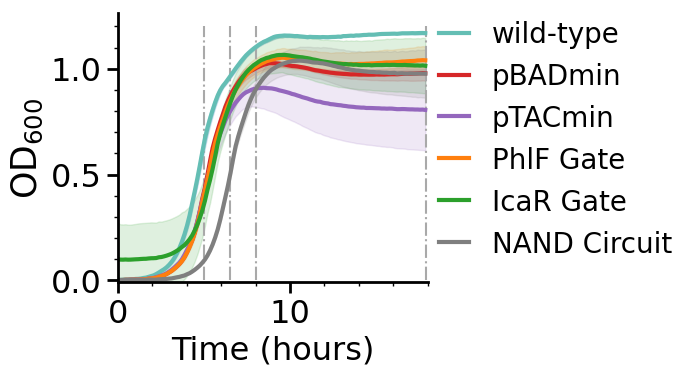

In [30]:
savefig = False

plt.figure(figsize=(4,3.5))
plt.plot(tspan,wt_mean,label='wild-type',lw=3,color=[100/255,190/255,180/255]) 
plt.fill_between(tspan,wt_mean-wt_std,wt_mean+wt_std,alpha=0.2,color='tab:blue')
#
plt.plot(tspan,bad_mean,label='pBADmin',lw=3,color='tab:red') 
plt.fill_between(tspan,bad_mean-bad_std,bad_mean+bad_std,alpha=0.15,color='tab:red')
#
plt.plot(tspan,tac_mean,label='pTACmin',lw=3,color='tab:purple') 
plt.fill_between(tspan,tac_mean-tac_std,tac_mean+tac_std,alpha=0.15,color='tab:purple')
#
plt.plot(tspan,phlf_mean,label='PhlF Gate',lw=3,color='tab:orange') 
plt.fill_between(tspan,phlf_mean-phlf_std,phlf_mean+phlf_std,alpha=0.15,color='tab:orange')
#
plt.plot(tspan,icar_mean,label='IcaR Gate',lw=3,color='tab:green') 
plt.fill_between(tspan,icar_mean-icar_std,icar_mean+icar_std,alpha=0.15,color='tab:green')
#
plt.plot(tspan,nand_mean,label='NAND Circuit',lw=3 ,color='tab:gray')
plt.fill_between(tspan,nand_mean-nand_std,nand_mean+nand_std,alpha=0.15,color='tab:gray')
#
plt.vlines(5,0,1.2,color='darkgray',linestyle='-.',linewidth=1.5)
plt.vlines(6.5,0,1.2,color='darkgray',linestyle='-.',linewidth=1.5)
plt.vlines(8,0,1.2,color='darkgray',linestyle='-.',linewidth=1.5)
plt.vlines(17.9,0,1.2,color='darkgray',linestyle='-.',linewidth=1.5)
plt.legend(frameon=False,fontsize=20,loc=(1,0.05),handlelength=1.1,fancybox=False,)
plt.xlabel('Time (hours)',fontsize=23); plt.ylabel(r'OD$_{600}$',fontsize=25)
plt.ylim(-0.01,)
plt.xlim(0,18)
if savefig: 
    plt.savefig(figDir+'fig2/ginkgo_growth_curves.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

### YFP output for distinct growth conditions in the NAND circuit

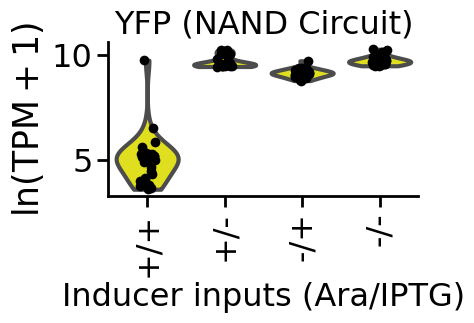

In [31]:
savefig = False
plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 

gray_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow", "yellow", "yellow"])
matplotlib.cm.register_cmap("mycolormap", gray_cmap)
cpal = sns.color_palette("mycolormap", n_colors=100, desat=1)

fig, ax = plt.subplots(figsize=(4,2))
this_ax = sc.pl.violin(adata[adata.obs.strain.isin(['NAND_Circuit'])].copy(),keys=['YFP'],groupby='input_state',
             ax=ax,size=7,rotation=90,cut=0,palette=cpal,show=False)#,save='_yfp_group_input_state.pdf') 
this_ax.set_ylabel(r'$\mathrm{ln}(\mathrm{TPM} + 1)$',fontsize=25)
this_ax.set_xlabel('Inducer inputs (Ara/IPTG)')
this_ax.set_title('YFP (NAND Circuit)',fontsize=23)
if savefig: 
    plt.savefig(figDir+'fig1/violin_NAND_yfp_group_input_state.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

### Total exogenous gene expression in each strain 

In [32]:
# get sum of gene expression of the 9 circuit genes on the circuit in that strain
# landing pads has only sensor array genes for 4 genes total on circuit
# pBADmin/pTACmin has sensor array (4) and YFP cassette (2) so 6 genes (doesn't have icar, phlf, and cmr)
# PhlF_Gate/IcaR_Gate only don't have their cassette counterpart for a total of 8 genes each
# NAND_Circuit has all 9 genes
circuit_exp = {}
for strain in adata.obs.strain.unique():
    circuit_exp[strain] = []
    zdata = adata[adata.obs.strain.isin([strain])].copy()
    for rep in zdata.obs.replicate.unique():
        zzdata = zdata[zdata.obs.replicate.isin([rep])].copy()
        circuit_exp[strain].append(zzdata.X[:,-9:].sum())
circuit_exp = pd.DataFrame(circuit_exp)
circuit_exp.drop('wild-type', axis=1, inplace=True)
circuit_exp = circuit_exp[['landing_pads','pBADmin','pTACmin',
                           'PhlF_Gate','IcaR_Gate','NAND_Circuit']]

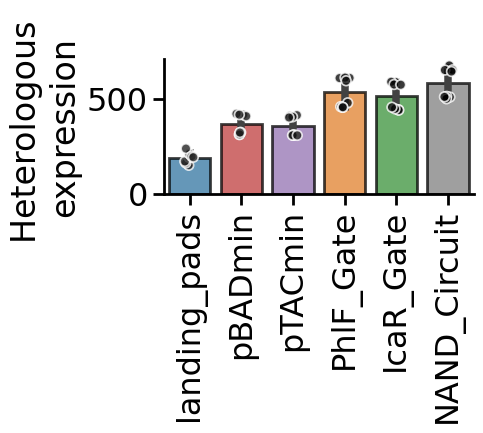

In [33]:
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.figure(figsize=(4,1.75))
sns.barplot(data=circuit_exp,
            palette=['tab:blue','tab:red','tab:purple','tab:orange','tab:green','tab:gray'],
           alpha=0.75,ci='sd',edgecolor='k',linewidth=2)
## plot a strip plot of the same data on top of the bar plot
ax = sns.stripplot(data=circuit_exp,
                   color='k',
                   linewidth=1.25, alpha=0.8,edgecolor='w',s=7)
plt.xticks(rotation=90)
plt.ylabel('Heterologous \nexpression',fontsize=24)
if savefig: 
    plt.savefig(figDir+'fig2/bar_total_exp_group_strain.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

### Perform PCA -> kNN -> Leiden -> UMAP analysis

In [35]:
sc.pp.pca(bdata,n_comps=25,random_state=0)
sc.pp.neighbors(bdata,n_neighbors=50,random_state=0)
sc.tl.leiden(bdata,resolution=1,random_state=0) 
sc.tl.umap(bdata,min_dist=1.9,random_state=0) 

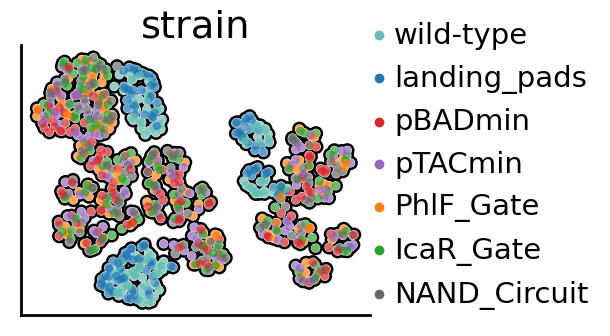

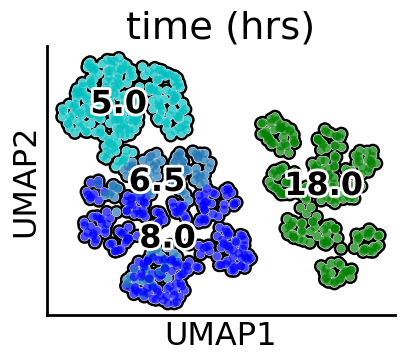

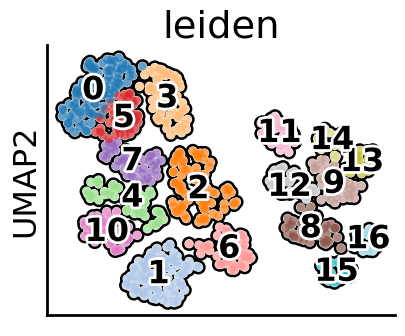

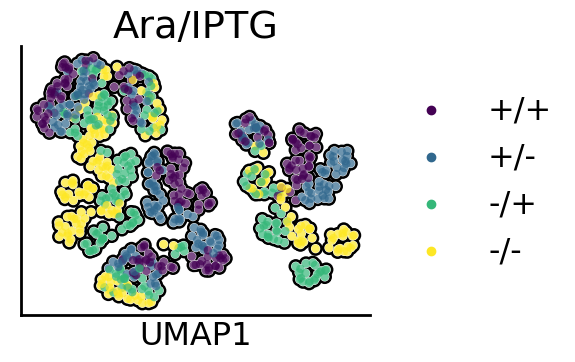

In [36]:
savefig = False

plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 

global_figsize = (4.5,3.5)
fig, ax = plt.subplots(figsize=global_figsize)
this_ax1 = sc.pl.umap(bdata,color='strain',
               palette=strain_palette,
               size=150,add_outline=True,show=False,ax=ax) # save='_umap_by_strain.pdf'
# for ii in range(len(strain_order_list)):
#     ax.plot([],[],'o',ms=7,color=strain_palette[ii],label=strain_order_list[ii])
ax.legend(frameon=False,loc=(0.91,-0.02),fontsize=21,handletextpad=-0.5)
this_ax1.set_ylabel(None)
this_ax1.set_xlabel(None) 
if savefig: 
    plt.savefig(figDir+'fig1/umap_genome_group_strain.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()
# #
fig, ax = plt.subplots(figsize=global_figsize)
this_ax2 = sc.pl.umap(bdata,color='timepoint',palette=['c','tab:blue','blue','g'],title='time (hrs)',
               legend_loc='on data',legend_fontoutline=4,size=150,add_outline=True,show=False,ax=ax) # save='_umap_by_time.pdf'
if savefig: 
    plt.savefig(figDir+'fig1/umap_genome_group_time.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()
#
fig, ax = plt.subplots(figsize=global_figsize)
this_ax3 = sc.pl.umap(bdata,color='leiden',legend_loc='on data',legend_fontoutline=4,legend_fontweight='heavy',
               palette='tab20',size=150,add_outline=True,show=False,ax=ax) # save='_umap_by_cluster.pdf'
this_ax3.set_xlabel(None)
if savefig: 
    plt.savefig(figDir+'fig1/umap_genome_group_leiden.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()
#
fig, ax = plt.subplots(figsize=global_figsize)
this_ax4 = sc.pl.umap(bdata,color='input_state',title='Ara/IPTG',palette='viridis',
               size=150,add_outline=True,show=False,ax=ax) # save='_umap_by_input_state.pdf'
this_ax4.set_ylabel(None)
if savefig: 
    plt.savefig(figDir+'fig1/umap_genome_group_input_state.pdf',bbox_inches='tight',transparent=True,dpi=300)    
plt.show()


In [31]:
sc.pp.pca(obdata,n_comps=25,random_state=0)
sc.pp.neighbors(obdata,n_neighbors=50,random_state=0)
sc.tl.leiden(obdata,resolution=1,random_state=0) 
sc.tl.umap(obdata,min_dist=1.9,random_state=0) 

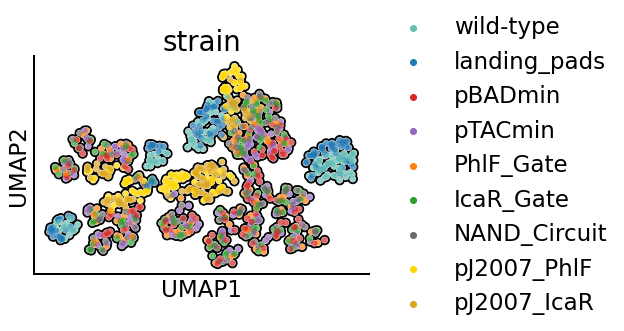

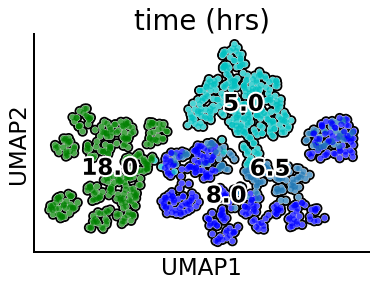

In [232]:
savefig = False

plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 

this_ax1 = sc.pl.umap(obdata,color='strain',
                      palette=[[100/255, 190/255, 180/255],
                    'tab:blue','tab:red','tab:purple','tab:orange','tab:green','dimgray','gold','goldenrod'],
               size=150,add_outline=True,show=False) 
if savefig: 
    plt.savefig(figDir+'fig1/umap_all_group_strain.pdf',bbox_inches='tight',transparent=True,dpi=300)    
#
this_ax2 = sc.pl.umap(obdata,color='timepoint',palette=['c','tab:blue','blue','g'],title='time (hrs)',
               legend_loc='on data',legend_fontoutline=4,size=150,add_outline=True,show=False)
if savefig: 
    plt.savefig(figDir+'fig1/umap_all_group_time.pdf',bbox_inches='tight',transparent=True,dpi=300)    

### Function to retrieve and parse gene ontology analysis results



In [46]:
def parse_go_json(go_json_file):

    with open(go_json_file) as f: 
        go = json.load(f)

    go_df = pd.DataFrame(columns=['biological_process','ngenes','gene_set','fold_enrichment','fdr'])
    for ii, functional_class in enumerate(go['overrepresentation']['group']):
        this_function = functional_class['result']
        go_dict = {}
        if type(this_function) == dict: # there is no functional subclass
            if this_function['input_list']['number_in_list'] != 0:
                bp = this_function['term']['label']
                ngenes = this_function['input_list']['number_in_list']
                gene_set = this_function['input_list']['mapped_id_list']['mapped_id']
                fold_enrichment = this_function['input_list']['fold_enrichment']
                fdr = this_function['input_list']['fdr']        
        else: # type(this_function) == list # there are functional subclasses, we only care for the first one i.e. the root node 
            if this_function[0]['input_list']['number_in_list'] != 0:
                bp = this_function[0]['term']['label']
                ngenes = this_function[0]['input_list']['number_in_list']
                gene_set = this_function[0]['input_list']['mapped_id_list']['mapped_id']
                fold_enrichment = this_function[0]['input_list']['fold_enrichment']
                fdr = this_function[0]['input_list']['fdr']
        go_dict['biological_process'] = bp
        go_dict['ngenes'] = ngenes
        go_dict['gene_set'] = gene_set
        go_dict['fold_enrichment'] = fold_enrichment
        go_dict['fdr'] = fdr

        go_df = go_df.append(go_dict,ignore_index=True)

    # grab all genes from gene_set in go_5hr
    all_genes_go = []
    for gene_set in go_df.gene_set:
        all_genes_go.append(gene_set)
    all_genes_go = [gene for sublist in all_genes_go for gene in sublist]
    
    return go_df, all_genes_go

### Sets of synthetic-construct-induced markers

In [47]:
ceroni_markers = ['htpG','ibpA','ibpB','dnaK','dnaJ','groS','groL'] # from literature (ceroni et al. burden driven feedback control)

circuit_markers = ['mepM','ykgL','ykgM','ykgO','zinT','znuA','znuB','znuC','pliG',
                   'ompR','narZ','narW','narY','narU','envZ','ymdF',
                   'csgE','csgD','greB','ompF'] + ['yjiH','yedE','yedF','hybO','ycbJ','iraD']  + \
                    ['yeeE','yeeD','cysP','cysU','cysA','cysJ','cysW']

# mqsR
# 1599 	3.959366e-01 	-0.527540 	dtpA 	0 	0.402374
# 1712 	9.416234e-02 	0.479918 	hybA 	0 	1.026123
# 3311 	3.377772e-01 	0.127240 	hybB 	0 	0.471370
# 3527 	8.848986e-01 	0.092589 	narV 	0 	0.053106
# 3557 	9.242450e-01 	-0.087408 	csgF 	0 	0.034213
# fruB

### Differential expression at 5 hours 

In [494]:
tdata = bdata[bdata.obs.timepoint.isin(['5.0'])].copy()

sc.tl.rank_genes_groups(tdata,'strain',groups=['NAND_Circuit'],reference='wild-type',method='wilcoxon',
                       rankby_abs=True)

pvals_adj = np.array(tdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64))
fdr = -np.log10(np.array(tdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64)))
logfcs = np.array(tdata.uns['rank_genes_groups']['logfoldchanges'].astype(np.float64))
names = (tdata.uns['rank_genes_groups']['names'])
names = [gene[0] for gene in names.tolist()]
rank_genes_df = pd.DataFrame(columns=['pvals_adj','logfcs','names','is_de'])
rank_genes_df['pvals_adj'] = pvals_adj
rank_genes_df['fdr'] = fdr
rank_genes_df['logfcs'] = logfcs
rank_genes_df['names'] = names

pval_cutoff = 0.05
logfc_cutoff = 0.5

is_de = np.array((rank_genes_df['pvals_adj'] <= pval_cutoff) & (np.abs(rank_genes_df['logfcs']) >= logfc_cutoff))*1
rank_genes_df['is_de'] = is_de
rank_genes_df.sort_values(by=['is_de','logfcs'],key=abs,ascending=False,inplace=True)
rank_genes_df.reset_index(drop=True,inplace=True)

de_genes_early = rank_genes_df[rank_genes_df['is_de']==1].names.tolist()

... storing 'timepoint' as categorical
... storing 'temperature' as categorical
... storing 'arabinose_unit' as categorical
... storing 'IPTG_unit' as categorical
... storing 'strain_input_state' as categorical
... storing 'input_state' as categorical
... storing 'strain1' as categorical


In [481]:
de_ceroni_early = rank_genes_df[rank_genes_df.names.isin(ceroni_markers)]
de_circuit_early = rank_genes_df[rank_genes_df.names.isin(circuit_markers)]

In [101]:
# rank_genes_df.to_csv('wilcoxon_5hrs_nand_vs_wt.csv',sep=',')

In [511]:
go_5hr, all_genes_go_5hr = parse_go_json('GO_analysis_5hrs.json')

In [512]:
go_5hr

,biological_process,ngenes,gene_set,fold_enrichment,fdr
0,bacterial-type flagellum assembly,15,"[flhA, flhB, flgA, flhD, fliG, fliI, fliK, frd...",4.784314,4.044223e-03
1,nitrate assimilation,16,"[narQ, narP, narV, narU, narZ, narY, narW, nrf...",4.592941,3.434190e-03
2,colanic acid biosynthetic process,14,"[wzc, wcaJ, wcaI, wcaG, wcaF, wcaE, cpsB, manA...",4.230341,1.254160e-02
3,aromatic amino acid family biosynthetic process,15,"[tyrA, aroL, tyrB, aroG, trpD, trpE, aroF, trp...",3.312217,3.873706e-02
4,anaerobic respiration,34,"[hybB, hybA, dcuB, hybC, yjjI, ynfE, hybO, acn...",3.200000,1.683109e-04
5,bacterial-type flagellum-dependent cell motility,27,"[frdA, frdB, frdC, flgA, fliC, flgB, fliD, flg...",3.100235,2.886293e-03
6,establishment of protein localization,36,"[csgE, oppC, oppD, csgF, oppF, oppA, oppB, yid...",2.222391,1.315219e-02
7,alpha-amino acid metabolic process,60,"[cysK, hemA, cysI, dsdA, cysJ, puuA, hemF, yib...",1.739750,1.900829e-02
8,transport,167,"[ompF, csgE, csgF, dcuB, chiP, nikA, dcuC, yeb...",1.346596,1.939475e-02
9,UNCLASSIFIED,87,"[yjdM, yibN, ygbE, ycbJ, ygfF, yebE, ybhB, yea...",0.507604,4.622506e-10


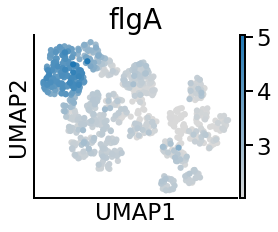

In [520]:
# gene which is differentially expressed at only this timepoint AND belongs to a highly overenriched gene set
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 

cmap = LinearSegmentedColormap.from_list(name='GyBu',colors=[[0.85]*3,'tab:blue'])

name = 'flgA'
fig, ax = plt.subplots(figsize=(4,3))
sc.pl.umap(bdata,color=name,cmap=cmap,vmin=0.8*bdata[:,name].X.mean(axis=0),ax=ax,show=False) # ,save='_fliK.pdf'
if savefig: 
    plt.savefig(figDir+'fig1/umap_flgA.pdf',transparent=True,bbox_inches='tight',dpi=300)


plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 


In [107]:
# add biological_process to gene in rank_genes_df for coloring in volcano plot
rank_genes_bioproc = ['N/A']*len(rank_genes_df)
rank_gene_list = []
for bioproc in go_5hr.biological_process:
    for genes in go_5hr[go_5hr.biological_process.isin([bioproc])].gene_set:
        for gene in genes: 
            if gene not in rank_gene_list:
                rank_genes_bioproc[rank_genes_df[rank_genes_df.names.isin([gene])].index[0]] = bioproc
            else: 
                rank_genes_bioproc[rank_genes_df[rank_genes_df.names.isin([gene])].index[0]] = \
                                    rank_genes_bioproc[rank_genes_df[rank_genes_df.names.isin([gene])].index[0]] \
                                        + ',' + bioproc
            rank_gene_list.append(gene)
rank_genes_df['biological_process'] = rank_genes_bioproc

In [108]:
# assign colors to genes based on de and bioprocess
rank_genes_colors = []
rank_genes_sizes = []
bioproc_plot = 'bacterial-type flagellum assembly'
for ii in range(len(rank_genes_df)):
    gene_de = rank_genes_df.loc[ii].is_de
    bioproc = rank_genes_df.loc[ii].biological_process
    if gene_de and bioproc_plot in bioproc:
#         rank_genes_colors.append(list(cmap(256)[0:3])+[1])
        rank_genes_colors.append('k')
        rank_genes_sizes.append(1000)
    elif gene_de and bioproc_plot not in bioproc:
#         rank_genes_colors.append(list(cmap(128)[0:3])+[0.4])
        rank_genes_colors.append(list(cmap(200)[0:3])+[0.7])
        rank_genes_sizes.append(100)
    elif not gene_de and bioproc_plot not in bioproc: 
        rank_genes_colors.append(list(cmap(0)[0:3])+[.55])
        rank_genes_sizes.append(10)

/usr/local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/usr/local/lib/python3.8/site-packages/seaborn/relational.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you mu

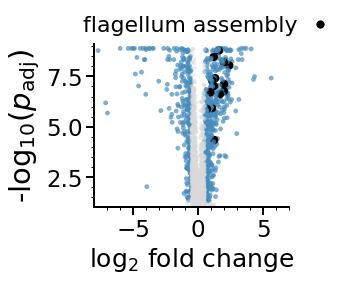

In [109]:
savefig = False

plt.figure(figsize=(3.5,3))
sns.scatterplot(x=rank_genes_df['logfcs'],y=rank_genes_df['fdr'],c=rank_genes_colors,size=rank_genes_sizes,
                legend=False,linewidth=0.0)
plt.xlabel(r'$\mathrm{log}_2$ fold change',fontsize=25)
plt.ylabel(r'-$\mathrm{log}_{10}(p_{\mathrm{adj}})$',fontsize=29)
plt.plot([],[],'o',color='k',label='flagellum assembly')
plt.legend(frameon=False,fontsize=22,loc=(-0.1,1),markerscale=1.2,markerfirst=False,handletextpad=0)
plt.xlim(-8,7)
plt.ylim(1,9.1)
if savefig: 
    plt.savefig(figDir+'fig1/lfcs_5hr.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

### Differential expression at 6.5/8.0 hours

In [521]:
tdata = bdata[bdata.obs.timepoint.isin(['6.5','8.0'])].copy()

sc.tl.rank_genes_groups(tdata,'strain',groups=['NAND_Circuit'],reference='wild-type',method='wilcoxon',
                       rankby_abs=True)

pvals_adj = np.array(tdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64))
fdr = -np.log10(np.array(tdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64)))
logfcs = np.array(tdata.uns['rank_genes_groups']['logfoldchanges'].astype(np.float64))
names = (tdata.uns['rank_genes_groups']['names'])
names = [gene[0] for gene in names.tolist()]
rank_genes_df = pd.DataFrame(columns=['pvals_adj','logfcs','names','is_de'])
rank_genes_df['pvals_adj'] = pvals_adj
rank_genes_df['fdr'] = fdr
rank_genes_df['logfcs'] = logfcs
rank_genes_df['names'] = names

pval_cutoff = 0.05
logfc_cutoff = 0.5

is_de = np.array((rank_genes_df['pvals_adj'] <= pval_cutoff) & (np.abs(rank_genes_df['logfcs']) >= logfc_cutoff))*1
rank_genes_df['is_de'] = is_de
rank_genes_df.sort_values(by=['is_de','logfcs'],key=abs,ascending=False,inplace=True)
rank_genes_df.reset_index(drop=True,inplace=True)

de_genes_mid = rank_genes_df[rank_genes_df['is_de']==1].names.tolist()

In [526]:
rank_genes_df[rank_genes_df.names.isin(['putA'])]

,pvals_adj,logfcs,names,is_de,fdr
22,9.699109e-11,-3.373015,putA,1,10.013268


In [527]:
2**(-3.373015)

0.09652088808353444

In [483]:
de_ceroni_mid = rank_genes_df[rank_genes_df.names.isin(ceroni_markers)]
de_circuit_mid = rank_genes_df[rank_genes_df.names.isin(circuit_markers)]

In [112]:
# rank_genes_df.to_csv('wilcoxon_6and8hrs_nand_vs_wt.csv',sep=',')

In [528]:
go_6and8hr, all_genes_go_6and8hr = parse_go_json('GO_analysis_6and8hrs.json')

In [114]:
go_6and8hr

,biological_process,ngenes,gene_set,fold_enrichment,fdr
0,slime layer polysaccharide biosynthetic process,9,"[wcaL, wcaK, wcaI, wcaF, wcaE, wcaD, wcaC, wca...",5.812941,0.037756
1,hexitol metabolic process,9,"[gatZ, uxaB, gatA, uxuB, gatB, gatD, mtlD, yei...",5.284492,0.046223
2,colanic acid biosynthetic process,15,"[wzc, wcaJ, wcaI, galE, wcaG, wcaF, wcaE, cpsB...",5.099071,0.004894
3,reactive nitrogen species metabolic process,14,"[narV, narU, narZ, narY, narX, hmp, narW, norW...",3.767647,0.035845
4,neutral amino acid transport,18,"[livK, alaE, livJ, sdaC, livM, gltL, glnH, rht...",3.321681,0.024839
5,cellular respiration,37,"[hybB, hybA, dcuB, gltA, hybC, aceK, cyoA, yjj...",2.096285,0.036012
6,cellular amino acid biosynthetic process,42,"[hisB, ilvC, hisC, hisD, leuL, argD, cysJ, met...",1.883824,0.047275
7,anion transport,53,"[dcuB, nikA, dcuC, cysA, chaA, glnH, cadB, arg...",1.773667,0.042935
8,alpha-amino acid metabolic process,54,"[leuL, argD, cysJ, puuA, gadA, gadB, glnA, yib...",1.761497,0.039479
9,transmembrane transport,131,"[ompF, csgE, yhhQ, csgF, dcuB, yhhS, nikA, dcu...",1.419641,0.025266


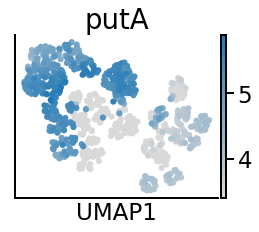

In [115]:
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 

name = 'putA' # 'putA' # 'modB' 
fig, ax = plt.subplots(figsize=(4,3))
thisax = sc.pl.umap(bdata,color=name,cmap=cmap,vmin=0.85*bdata[:,name].X.mean(axis=0)
           ,ax=ax,show=False) # ,save='_putA.pdf'
thisax.set_ylabel(None)

if savefig: 
    plt.savefig(figDir+'fig1/umap_putA.pdf',transparent=True,bbox_inches='tight',dpi=300)

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 


In [116]:
# add biological_process to gene in rank_genes_df for coloring in volcano plot
rank_genes_bioproc = ['N/A']*len(rank_genes_df)
rank_gene_list = []
for bioproc in go_6and8hr.biological_process:
    for genes in go_6and8hr[go_6and8hr.biological_process.isin([bioproc])].gene_set:
        for gene in genes: 
            if gene not in rank_gene_list:
                rank_genes_bioproc[rank_genes_df[rank_genes_df.names.isin([gene])].index[0]] = bioproc
            else: 
                rank_genes_bioproc[rank_genes_df[rank_genes_df.names.isin([gene])].index[0]] = \
                                    rank_genes_bioproc[rank_genes_df[rank_genes_df.names.isin([gene])].index[0]] \
                                        + ',' + bioproc
            rank_gene_list.append(gene)
rank_genes_df['biological_process'] = rank_genes_bioproc

In [117]:
# assign colors to genes based on de and bioprocess
rank_genes_colors = []
rank_genes_sizes = []
bioproc_plot = 'cellular amino acid biosynthetic process'
for ii in range(len(rank_genes_df)):
    gene_de = rank_genes_df.loc[ii].is_de
    bioproc = rank_genes_df.loc[ii].biological_process
    if gene_de and bioproc_plot in bioproc:
#         rank_genes_colors.append(list(cmap(256)[0:3])+[1])
        rank_genes_colors.append('k')
        rank_genes_sizes.append(1000)
    elif gene_de and bioproc_plot not in bioproc:
#         rank_genes_colors.append(list(cmap(128)[0:3])+[0.4])
        rank_genes_colors.append(list(cmap(200)[0:3])+[0.7]) # TO-DO: INCREASE ALPHA
        rank_genes_sizes.append(100)
    elif not gene_de and bioproc_plot not in bioproc: 
        rank_genes_colors.append(list(cmap(0)[0:3])+[.55])
        rank_genes_sizes.append(10)

/usr/local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/usr/local/lib/python3.8/site-packages/seaborn/relational.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you mu

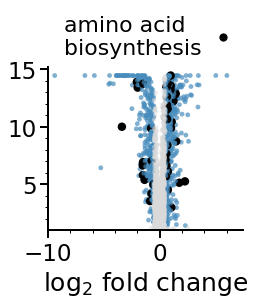

In [125]:
savefig = False

plt.figure(figsize=(3.5,3))
sns.scatterplot(x=rank_genes_df['logfcs'],y=rank_genes_df['fdr'],c=rank_genes_colors,size=rank_genes_sizes,
                legend=False,linewidth=0)
plt.xlabel(r'$\mathrm{log}_2$ fold change',fontsize=25)
# plt.ylabel(r'-$\mathrm{log}_{10}(p_{\mathrm{adj}})$',fontsize=29)
plt.ylabel(None)
plt.plot([],[],'o',color='k',label=' amino acid \n biosynthesis')
plt.legend(frameon=False,fontsize=22,loc=(0.0,1),markerscale=1.2,markerfirst=False,handletextpad=0)
plt.xlim(-10,7.5)
plt.ylim(1,)
if savefig: 
    plt.savefig(figDir+'fig1/lfcs_6and8hr.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

### Differential expression at 18 hours

In [531]:
tdata = bdata[bdata.obs.timepoint.isin(['18.0'])].copy()

sc.tl.rank_genes_groups(tdata,'strain',groups=['NAND_Circuit'],reference='wild-type',method='wilcoxon',
                       rankby_abs=True)

pvals_adj = np.array(tdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64))
fdr = -np.log10(np.array(tdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64)))
logfcs = np.array(tdata.uns['rank_genes_groups']['logfoldchanges'].astype(np.float64))
names = (tdata.uns['rank_genes_groups']['names'])
names = [gene[0] for gene in names.tolist()]
rank_genes_df = pd.DataFrame(columns=['pvals_adj','logfcs','names','is_de'])
rank_genes_df['pvals_adj'] = pvals_adj
rank_genes_df['fdr'] = fdr
rank_genes_df['logfcs'] = logfcs
rank_genes_df['names'] = names

pval_cutoff = 0.05
logfc_cutoff = 0.5

is_de = np.array((rank_genes_df['pvals_adj'] <= pval_cutoff) & (np.abs(rank_genes_df['logfcs']) >= logfc_cutoff))*1
rank_genes_df['is_de'] = is_de
rank_genes_df.sort_values(by=['is_de','logfcs'],key=abs,ascending=False,inplace=True)
rank_genes_df.reset_index(drop=True,inplace=True)

de_genes_late = rank_genes_df[rank_genes_df['is_de']==1].names.tolist()

In [485]:
de_ceroni_late = rank_genes_df[rank_genes_df.names.isin(ceroni_markers)]
de_circuit_late = rank_genes_df[rank_genes_df.names.isin(circuit_markers)]

In [128]:
# rank_genes_df.to_csv('wilcoxon_18hrs_nand_vs_wt.csv',sep=',')

In [532]:
go_18hr, all_genes_go_18hr = parse_go_json('GO_analysis_18hrs.json')

In [130]:
go_18hr

,biological_process,ngenes,gene_set,fold_enrichment,fdr
0,hydrogen sulfide biosynthetic process,6,"[cysI, cysJ, cysH, cysC, cysD, cysN]",14.837838,0.042066
1,glyoxylate cycle,6,"[iclR, aceB, aceA, aceK, icd, acnB]",11.128378,0.046003
2,tricarboxylic acid cycle,15,"[gltA, aceK, icd, aspA, aceB, aceA, sucC, sucD...",7.674744,0.000097
3,alpha-amino acid metabolic process,30,"[ilvD, cysK, cysI, leuL, cysJ, ilvE, puuA, gad...",2.248157,0.050000


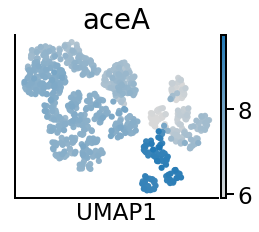

In [544]:
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 

name = 'aceA'
fig, ax = plt.subplots(figsize=(4,3))
thisax = sc.pl.umap(bdata,color=name,cmap=cmap,vmin=0.8*bdata[:,name].X.mean(axis=0),ax=ax,show=False) # ,save='_icd.pdf' 
thisax.set_ylabel(None)
if savefig: 
    plt.savefig(figDir+'fig1/umap_aceA.pdf',transparent=True,bbox_inches='tight',dpi=300)
    
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 


In [132]:
# add biological_process to gene in rank_genes_df for coloring in volcano plot
rank_genes_bioproc = ['N/A']*len(rank_genes_df)
rank_gene_list = []
for bioproc in go_18hr.biological_process:
    for genes in go_18hr[go_18hr.biological_process.isin([bioproc])].gene_set:
        for gene in genes: 
            if gene not in rank_gene_list:
                rank_genes_bioproc[rank_genes_df[rank_genes_df.names.isin([gene])].index[0]] = bioproc
            else: 
                rank_genes_bioproc[rank_genes_df[rank_genes_df.names.isin([gene])].index[0]] = \
                                    rank_genes_bioproc[rank_genes_df[rank_genes_df.names.isin([gene])].index[0]] \
                                        + ',' + bioproc
            rank_gene_list.append(gene)
rank_genes_df['biological_process'] = rank_genes_bioproc

In [133]:
# assign colors to genes based on de and bioprocess
rank_genes_colors = []
rank_genes_sizes = []
bioproc_plot = 'tricarboxylic acid cycle'
for ii in range(len(rank_genes_df)):
    gene_de = rank_genes_df.loc[ii].is_de
    bioproc = rank_genes_df.loc[ii].biological_process
    if gene_de and bioproc_plot in bioproc:
#         rank_genes_colors.append(list(cmap(256)[0:3])+[1])
        rank_genes_colors.append('k')
        rank_genes_sizes.append(1000)
    elif gene_de and bioproc_plot not in bioproc:
#         rank_genes_colors.append(list(cmap(128)[0:3])+[0.4])
        rank_genes_colors.append(list(cmap(200)[0:3])+[0.7])
        rank_genes_sizes.append(100)
    elif not gene_de and bioproc_plot not in bioproc: 
        rank_genes_colors.append(list(cmap(0)[0:3])+[.55])
        rank_genes_sizes.append(10)

/usr/local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/usr/local/lib/python3.8/site-packages/seaborn/relational.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you mu

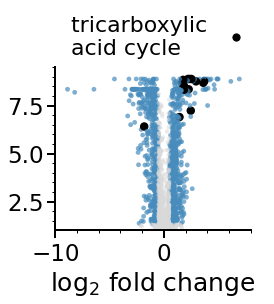

In [138]:
savefig = False

plt.figure(figsize=(3.5,3))
sns.scatterplot(x=rank_genes_df['logfcs'],y=rank_genes_df['fdr'],c=rank_genes_colors,size=rank_genes_sizes,
                legend=False,linewidth=0.0)
plt.xlabel(r'$\mathrm{log}_2$ fold change',fontsize=25)
# plt.ylabel(r'-$\mathrm{log}_{10}(p_{\mathrm{adj}})$',fontsize=29)
plt.ylabel(None)
plt.plot([],[],'o',color='k',label=' tricarboxylic \n acid cycle')
plt.legend(frameon=False,fontsize=22,loc=(-0.0,1),markerscale=1.2,markerfirst=False,handletextpad=0)
plt.xlim(-10,8)
plt.ylim(1,9.5)
if savefig: 
    plt.savefig(figDir+'fig1/lfcs_18hr.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

### Differential expression between pTACmin and other strains (set subtract the genes that are de b/w pTACmin and wild-type)

In [34]:
sc.tl.rank_genes_groups(bdata,'strain',groups=['pTACmin'],reference='pBADmin',method='wilcoxon',
                       rankby_abs=True)

pvals_adj = np.array(bdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64))
fdr = -np.log10(np.array(bdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64)))
logfcs = np.array(bdata.uns['rank_genes_groups']['logfoldchanges'].astype(np.float64))
names = (bdata.uns['rank_genes_groups']['names'])
names = [gene[0] for gene in names.tolist()]
rank_genes_df = pd.DataFrame(columns=['pvals_adj','logfcs','names','is_de'])
rank_genes_df['pvals_adj'] = pvals_adj
rank_genes_df['fdr'] = fdr
rank_genes_df['logfcs'] = logfcs
rank_genes_df['names'] = names

pval_cutoff = 0.05
logfc_cutoff = 0.5

is_de = np.array((rank_genes_df['pvals_adj'] <= pval_cutoff) & (np.abs(rank_genes_df['logfcs']) >= logfc_cutoff))*1
rank_genes_df['is_de'] = is_de
rank_genes_df.sort_values(by=['is_de','logfcs'],key=abs,ascending=False,inplace=True)
rank_genes_df.reset_index(drop=True,inplace=True)

In [35]:
rank_genes_df[rank_genes_df.is_de.isin([1])]

,pvals_adj,logfcs,names,is_de,fdr
0,6.994761e-14,2.652556,flu,1,13.155227
1,3.136014e-12,1.756803,yeeR,1,11.503622
2,4.379246e-23,0.988316,yeeS,1,22.358601
3,1.008872e-08,0.704239,fecB,1,7.996164
4,1.575131e-07,0.536383,fecC,1,6.802683


In [37]:
tac_fit_markers = ['flu','yeeR','yeeS']

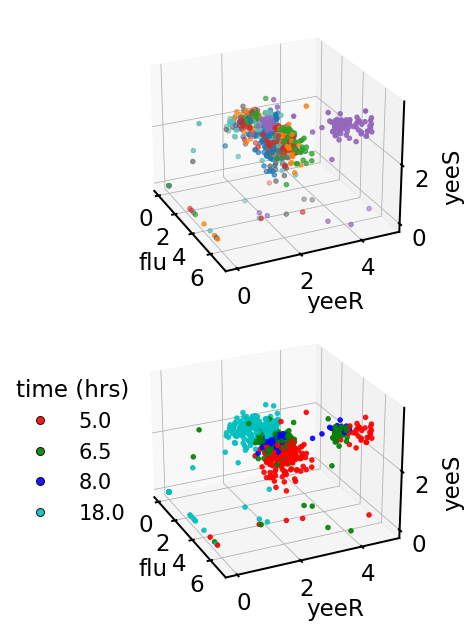

In [36]:
# difference between flu, yeeR, and yeeS in all strains
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 


fig = plt.figure(figsize=(11,11))
xgene = 'flu'; ygene = 'yeeR'; zgene = 'yeeS'
ax = fig.add_subplot(211, projection = '3d')
ax.view_init(elev=25, azim=335)

d = {strain: ii for ii, strain in enumerate(strain_order_list)}
numbers = [d[ii] for ii in adata.obs.strain.tolist()]
colors = [strain_palette[ii] for ii in numbers]

ax.set_xlabel(xgene,labelpad=10)
ax.set_ylabel(ygene,labelpad=15)
ax.set_zlabel(zgene,labelpad=8,rotation=90)

ax.scatter(adata[:,xgene].X.reshape(-1),adata[:,ygene].X.reshape(-1),adata[:,zgene].X.reshape(-1),
                 c=colors)#,s=75,edgecolor='k',linewidth=0.75,alpha=0.9)

# # for legend
# for ii in range(len(strain_palette)):
#     plt.plot([],[],'o',color=strain_palette[ii],label=strain_order_list[ii],mec='k',ms=8,alpha=0.9)
# plt.legend(frameon=False,fontsize=20,loc=(1.15,0.05))

ax = fig.add_subplot(212, projection = '3d')
ax.view_init(elev=25, azim=335)

d = {strain: ii for ii, strain in enumerate(['5.0','6.5','8.0','18.0'])}
numbers = [d[ii] for ii in adata.obs.timepoint.tolist()]
colors = [['r','b','g','c'][ii] for ii in numbers] 
ax.set_xlabel(xgene,labelpad=10)
ax.set_ylabel(ygene,labelpad=15)
ax.set_zlabel(zgene,labelpad=8,rotation=90)

ax.scatter(adata[:,xgene].X.reshape(-1),adata[:,ygene].X.reshape(-1),adata[:,zgene].X.reshape(-1),
          color=colors,alpha=0.9)
# for legend
for ii in range(len(['5.0','6.5','8.0','18.0'])):
    plt.plot([],[],'o',color=['r','g','b','c'][ii],label=['5.0','6.5','8.0','18.0'][ii],ms=8,mec='k',alpha=0.9)
plt.legend(frameon=False,fontsize=21,loc=(-0.4,0.25),title='time (hrs)')
plt.subplots_adjust(hspace=0.05)

if savefig: 
    plt.savefig(figDir+'fig2/scatter_tacfitgenes_strain_timepoint.pdf',bbox_inches='tight',transparent=True,dpi=300)

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

In [165]:
# correlate flu, yeeR, and yeeS in pTACmin with circuit gene
cdata = adata[adata.obs.strain.isin(['pTACmin'])].copy()


tac_fit_corr = np.zeros((len(circuit_genes),len(tac_fit_markers)))
for ii, circuit_gene in enumerate(circuit_genes): 
    for jj, marker_gene in enumerate(tac_fit_markers): 
        rho, _ = sp.stats.pearsonr(cdata[:,circuit_gene].X.reshape(-1),cdata[:,marker_gene].X.reshape(-1))
        tac_fit_corr[ii,jj] = rho

/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


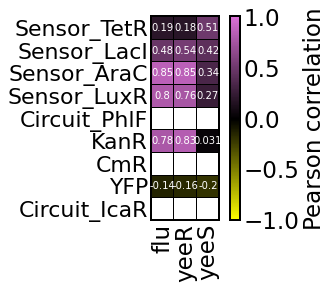

In [166]:
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True;
plt.rcParams['xtick.major.size'] = 0;
plt.rcParams['ytick.major.size'] = 0;

ybp_cmap = LinearSegmentedColormap.from_list(name='ybpcmap', colors=['yellow','black','orchid'])

fig, ax = plt.subplots(figsize=(15,4.5))
hax = sns.heatmap(tac_fit_corr,cmap=ybp_cmap,square=True,ax=ax,
            yticklabels=circuit_genes,xticklabels=tac_fit_markers,vmax=-1,vmin=1,linewidths=0.005,linecolor='k',
            cbar_kws={'pad':0.01,'label':'Pearson correlation','shrink':1},annot=True,annot_kws={'fontsize':10})
cbar_ax = fig.axes[-1] 
cbar_ax.set_frame_on(True)
for _, spine in hax.spines.items():
    spine.set_visible(True)
plt.xticks(np.arange(0,len(tac_fit_markers))+0.5,tac_fit_markers)
plt.yticks(np.arange(0,len(circuit_genes))+0.5,circuit_genes,fontsize=22)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'fig1/heatmap_biomarkers_fit_circuit.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 
plt.rcParams['xtick.major.size'] = 8;
plt.rcParams['ytick.major.size'] = 8;

<ipython-input-478-ae549e638b78>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


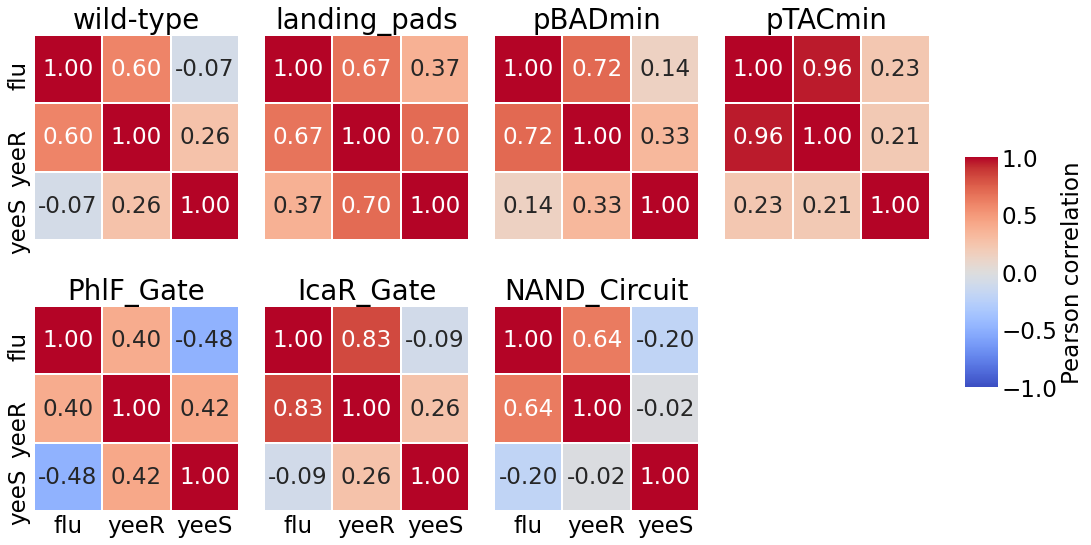

In [478]:
# correlate flu, yeeS, and yeeR with each other

savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True;
plt.rcParams['xtick.major.size'] = 0;
plt.rcParams['ytick.major.size'] = 0;

tac_fit_markers = ['flu','yeeR','yeeS']
fig, ax = plt.subplots(2,4,figsize=(15,8),sharex=True,sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
fig.delaxes(ax[-1,-1])
ax = ax.reshape(-1)
for ii, strain in enumerate(strain_order_list):
    ax[ii].set_title(strain)
    aa = np.corrcoef(adata[adata.obs.strain.isin([strain]),tac_fit_markers].X.toarray().T)
    sns.heatmap(aa,cmap='coolwarm',vmin=-1,vmax=1,xticklabels=tac_fit_markers,yticklabels=tac_fit_markers,square=True,
            linewidths=1,ax=ax[ii],annot=True,fmt='.2f',cbar= ii==0, cbar_ax=None if ii else cbar_ax,cbar_kws={'label':'Pearson correlation'}) 
# sns.heatmap(bb,cmap='coolwarm',vmin=-1,vmax=1,xticklabels=tac_fit_markers,yticklabels=tac_fit_markers,square=True,
#             linewidths=1,ax=ax[1],annot=True,cbar_kws={'shrink':0.7})
fig.tight_layout(rect=[0, 0, .9, 1])
if savefig: 
    plt.savefig(figDir+'supplementalFigs/heatmap_tacfit_genes_corr.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 
plt.rcParams['xtick.major.size'] = 8;
plt.rcParams['ytick.major.size'] = 8;

How well does the expression of flu, yeeS, and yeeR correlate with final OD?

In [29]:
od_data = {'wild-type':nand_od[:,[9,21,33,45]],'pBADmin':nand_od[:,[4,16,28,40]],
         'pTACmin':nand_od[:,[5,17,29,41]],'PhlF_Gate':nand_od[:,[0,12,24,36]],
         'IcaR_Gate':nand_od[:,[1,13,25,37]],'NAND_Circuit':nand_od[:,[2,14,26,38]]}

In [30]:
def pred_od(gene_list=['flu','yeeR','yeeS'],reg=0.0):
    
    rna_data = {'wild-type':adata[adata.obs.strain.isin(['wild-type']),gene_list].copy(),
            'pBADmin':adata[adata.obs.strain.isin(['pBADmin']),gene_list].copy(),
            'pTACmin':adata[adata.obs.strain.isin(['pTACmin']),gene_list].copy(),
            'PhlF_Gate':adata[adata.obs.strain.isin(['PhlF_Gate']),gene_list].copy(),
            'IcaR_Gate':adata[adata.obs.strain.isin(['IcaR_Gate']),gene_list].copy(),
            'NAND_Circuit':adata[adata.obs.strain.isin(['NAND_Circuit']),gene_list].copy()}
    
    od_all = np.zeros((1,len(rna_data))) 
    od_std = np.zeros_like(od_all)
    rna_all = np.zeros((len(gene_list),len(rna_data)))
    # generate a data matrix containing all replicates for visualization
    for ii, strain in enumerate(['wild-type','pBADmin','pTACmin','PhlF_Gate','IcaR_Gate','NAND_Circuit']):
        rna_all[:,ii] = rna_data[strain].X.mean(axis=0)
        od_all[:,ii] = od_data[strain].mean(axis=1)[-1]
        od_std[:,ii] = od_data[strain].std(axis=1)[-1]
    
    mse_list = []
    nreps_rna = len(adata.obs.replicate.unique())
    K = 8 # subsample total replicates to K from RNA
    nreps_od = 4 # number of OD replicates
    rna_ = np.zeros_like(rna_all)
    rna_val = np.zeros_like(rna_all)
    od_ = np.zeros_like(od_all) # train
    od_val = np.zeros_like(od_all) # val
    pred_list = [] # OD predictions
    # first get all combinations of K replicates of RNA data
    for ii, reps in enumerate(combinations(range(1,nreps_rna+1),K)):
        reps = list(reps)
        # 4-fold split of the data for train/val (subset to 3 replicates in each)
        for rnareps in (combinations(reps,len(reps)-1)): # od has only 4 replicates
            for odreps in combinations(range(nreps_od),nreps_od-1):
                val_rnarep = list(set(reps) - set(list(rnareps)))
                val_odrep = list(set(range(nreps_od)) - set(odreps))
                # grab data per strain
                for jj, strain in enumerate(['wild-type','pBADmin','pTACmin','PhlF_Gate','IcaR_Gate','NAND_Circuit']):
                    sub_obs = rna_data[strain].obs.replicate.isin(rnareps) 
                    sub_obs_val = rna_data[strain].obs.replicate.isin(val_rnarep)
                    rna_[:,jj] = rna_data[strain][sub_obs].X.toarray().mean(axis=0) # average across all replicates
                    od_[:,jj] = od_data[strain][:,odreps].mean(axis=1)[-1] # average across replicates, then grab last time point   
                    rna_val[:,jj] = rna_data[strain][sub_obs_val].X.toarray().mean(axis=0)
                    od_val[:,jj] = od_data[strain][:,val_odrep].mean(axis=1)[-1]
                    alpha = (od_ @ rna_.T @ np.linalg.pinv(rna_ @ rna_.T + reg*np.eye(len(rna_)) )).reshape(-1)            
                    pred_list.append( (alpha.reshape(1,-1) @ rna_val).T ) 
                    mse_list.append( mean_squared_error((alpha.reshape(1,-1) @ rna_val).T, od_val.T) )
    pred_mean = np.array(pred_list).mean(axis=0)
    corr_mean = sp.stats.pearsonr(pred_mean.reshape(-1),od_all.reshape(-1))
        
    return pred_mean, np.array(pred_list).std(axis=0), mse_list, corr_mean, od_all, od_std, rna_all


In [257]:
pred_mean, pred_std, mse_list, corr, od_mean, od_std, rna_mean = pred_od(gene_list=['flu','yeeR','yeeS'],reg=0.0)
# pred_mean, pred_std, mse_list, corr, od_mean, od_std, rna_mean = pred_od(gene_list=['creB', 'metQ', 'yjfL'],reg=0.0)
corr

(0.9750362944300006, 0.0009270013703322462)

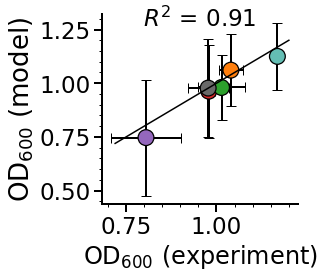

In [142]:
savefig = False

plt.figure(figsize=(3.5,3.5))
plt.errorbar(od_mean.reshape(-1),pred_mean,xerr=od_std.reshape(-1)/2,yerr=pred_std.reshape(-1)/2,color='k',capsize=5,linewidth=2,ms=0,fmt='o',zorder=0)
plt.scatter(od_mean.reshape(-1),pred_mean.reshape(-1),c=[strain_palette[0]]+strain_palette[2:],s=250,edgecolors='k',linewidth=1.25) # facecolors='none',linewidth=2.25
# plt.title(f'mse = {mean_squared_error(od_mean.reshape(-1),pred_mean.reshape(-1)):.2f}')
plt.title(f'$R^2$ = {r2_score(pred_mean.reshape(-1),od_mean.reshape(-1)):.2f}',fontsize=23,y=0.9)
# plt.xlim(0.4,1.4)
# plt.ylim(0.4,1.4)
plt.plot([0.72,1.2],[0.72,1.2],c='k',lw=1.5)
plt.xlabel(r'OD$_{600}$ (experiment)',fontsize=24)
plt.ylabel(r'OD$_{600}$ (model)',fontsize=26)
if savefig: 
    plt.savefig(figDir+'fig2/scatter_predict_OD_tacfit_genes.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [251]:
doRun = False
doSave = False

nruns = 500
if doRun:
    random_corr_list = []
    for ii in range(nruns):
        varinds = choices(list(range(bdata.n_vars)),k=3)
        var_names = adata.var_names[varinds].tolist()
        _, _, _, random_corr, _, _, _ = pred_od(gene_list=var_names,reg=0.0) 
        random_corr_list.append(random_corr[0])
        if ii % 10 == 0:
            print(ii)
    
    if doSave:
        pd.DataFrame(random_corr_list).to_csv('od_corr_triplets_of_genes.csv',index=False)
    
else: 
    random_corr_list = (pd.read_csv('od_corr_triplets_of_genes.csv')).values.reshape(-1).tolist()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


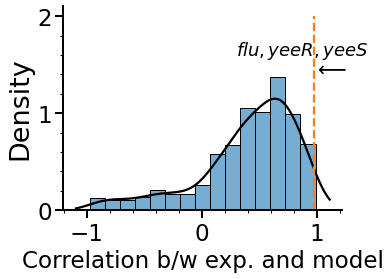

In [282]:
savefig = False

plt.figure(figsize=(5,3.75))
sns.kdeplot(random_corr_list+[corr[0]],color='k',linewidth=2.25,shade=False,alpha=0.1,gridsize=500,cut=1)
# sns.histplot(random_corr_list+[corr[0]],bins=500,color='b',alpha=0.4)
plt.hist(random_corr_list+[corr[0]],bins=15,density=True,facecolor='tab:blue',alpha=0.6)
output = plt.hist(random_corr_list+[corr[0]],bins=15,density=True,facecolor="None",edgecolor='k',linewidth=1)
plt.plot([corr[0],corr[0]],[0,2],'--',color='tab:orange',lw=2.25)

# plt.xlim(-0.6,1)
# plt.ylim(0,8.0)
plt.text(corr[0]+0.000,1.4,r'$\longleftarrow$',fontsize=20)
plt.text(corr[0]*0.3,1.6,'$\it{flu, yeeR, yeeS}$',fontsize=18)
# plt.text(-0.59,5,'other gene sets',fontsize=18)
# plt.title(r'$2000$ randomly selected' '\n triplets of genes',fontsize=20)
plt.ylabel('Density',fontsize=27)
plt.xlabel('Correlation b/w exp. and model')

## p-value for achieving less mse than obtained from (flu, yeeR, yeeS) given the above cdf
# p, bins = output[0], output[1]
# pbin = np.where((bins<=corr[0]))[0][-1] + 1
# pval = (p[pbin] + p[pbin-1])/2
# pval

# plt.text(corr[0]+0.0003,0.6,f'p={pval:.3f}',fontsize=16)

if savefig: 
    plt.savefig(figDir+'fig2/cdf_odcorr.pdf',bbox_inches='tight',transparent=True,dpi=300)

plt.show()


0.0019960079840315448


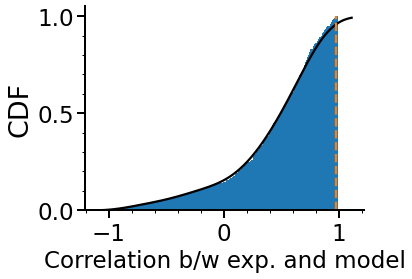

In [295]:

plt.figure(figsize=(5,3.75))
sns.kdeplot(random_corr_list+[corr[0]],color='k',linewidth=2.25,shade=False,alpha=0.1,gridsize=500,cut=1,cumulative=True)
# sns.histplot(random_corr_list+[corr[0]],bins=500,color='b',alpha=0.4)
# plt.hist(random_corr_list+[corr[0]],bins=15,density=True,facecolor='tab:blue',alpha=0.6)
output = plt.hist(random_corr_list+[corr[0]],bins=200,density=True, cumulative=True)
plt.plot([corr[0],corr[0]],[0,1],'--',color='tab:orange',lw=2.25)

# plt.xlim(-0.6,1)
# plt.ylim(0,8.0)
# plt.text(corr[0]+0.000,1.4,r'$\longleftarrow$',fontsize=20)
# plt.text(corr[0]*0.3,1.6,'$\it{flu, yeeR, yeeS}$',fontsize=18)
# plt.text(-0.59,5,'other gene sets',fontsize=18)
# plt.title(r'$2000$ randomly selected' '\n triplets of genes',fontsize=20)
plt.ylabel('CDF',fontsize=27)
plt.xlabel('Correlation b/w exp. and model')

# p-value for achieving less mse than obtained from (flu, yeeR, yeeS) given the above cdf
p, bins = output[0], output[1]
pbin = np.where((bins<=corr[0]))[0][-1] + 1
pval = 1 - (p[pbin] + p[pbin-1])/2
print(1 - pval)

# plt.text(corr[0]+0.0003,0.6,f'p={pval:.3f}',fontsize=16)


plt.show()


### Synthetic cell state genes

In [510]:
sc.pl.umap(bdata,color='strain',
           palette=[[100/255, 190/255, 180/255],
                'tab:blue','tab:red','tab:purple','tab:orange','tab:green','dimgray'],
           size=150,add_outline=True,show=False)
# strangely, have to run this to set the colors for the groupby in the heatmap below
plt.close()

In [511]:
adata_cl = adata[~adata.obs.strain.isin(['wild-type'])].copy()
adata_cnol = adata[~adata.obs.strain.isin(['wild-type','landing_pads'])].copy()
adata_w = adata[adata.obs.strain.isin(['wild-type'])].copy()

wl = 1
po = 0

syn_cv =  (np.std(sg(adata_cnol[:,circuit_markers].X.toarray(),wl,po),axis=0)) #/ 
#            (np.mean(sg(adata_cnol[:,circuit_markers].X.toarray(),wl,po),axis=0)) )

de_genes_minsyn = list(set(de_genes_early).intersection(set(de_genes_mid)).intersection(set(de_genes_late)) - set(circuit_markers)) # minus circuit marker genes (which are also de at all tps)
de_genes_minsyn.remove('fruB')
de_cv =  np.std(sg(adata_cnol[:,de_genes_minsyn].X.toarray(),wl,po),axis=0) #/ 
#           np.mean(sg(adata_cnol[:,de_genes_minsyn].X.toarray(),wl,po),axis=0) )

dist_de_genes = np.sqrt((sg(adata_w[:,de_genes_minsyn].X.toarray(),wl,po).mean(axis=0)  - 
                                 sg(adata_cnol[:,de_genes_minsyn].X.toarray(),wl,po).mean(axis=0) )**2)

dist_circuit = np.sqrt((sg(adata_w[:,circuit_markers].X.toarray(),wl,po).mean(axis=0)  - 
                                 sg(adata_cnol[:,circuit_markers].X.toarray(),wl,po).mean(axis=0) )**2)

del adata_cl, adata_cnol, adata_w

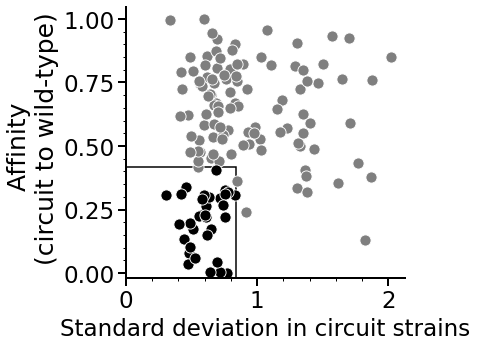

In [512]:
savefig = False

plt.figure(figsize=(5,5))
currentAxis = plt.gca()
currentAxis.add_patch(matplotlib.patches.Rectangle((0.0, -0.02), 0.84, np.exp(-0.8778816)+0.02, alpha=1, facecolor='none',edgecolor='k',linewidth=1.5,zorder=0))
sns.scatterplot(x=de_cv,y=np.exp(-dist_de_genes/1),s=125,color='tab:gray')
sns.scatterplot(x=syn_cv,y=np.exp(-dist_circuit/1),s=125,color='k')
# for ii,(x,y) in enumerate(zip(syn_cv,dist_circuit)):
#     if y >= 0.8778816 and x <= 0.84:
#         plt.text(x,np.exp(-y),circuit_markers[ii],fontsize=10)
# for ii,(x,y) in enumerate(zip(de_cv,dist_de_genes)):
#     if y >= 0.8778816 and x <= 0.84:
#         plt.text(x,y,de_genes_minsyn[ii],fontsize=20)
# plt.title('Synthetic construct biomarkers',fontsize=21)
plt.ylim(-0.02,)
plt.xlim(0,)
plt.xlabel('Standard deviation in circuit strains')
plt.ylabel('Affinity \n (circuit to wild-type)',fontsize=25) # defined as $exp(-|| x_{\mathrm{circuit}} - x_{\mathrm{wild-type}} ||_2^2)$ 
if savefig: 
    plt.savefig(figDir+'fig3/scatter_std_aff.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

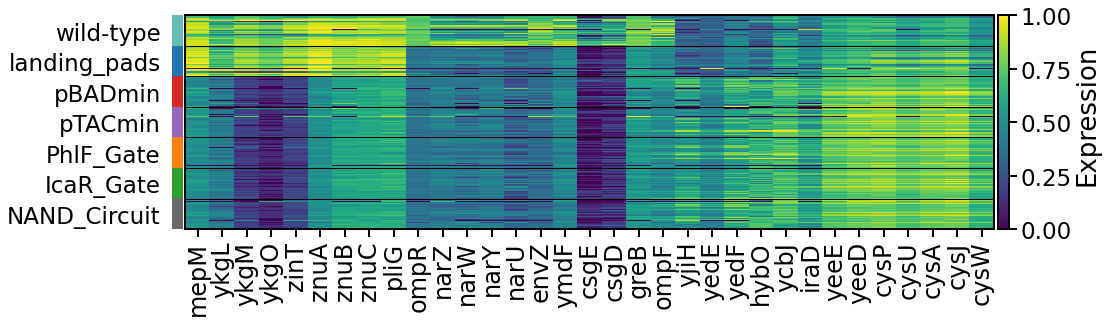

In [521]:
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True; 

this_ax = sc.pl.heatmap(bdata, var_names=circuit_markers, 
              groupby='strain',
              swap_axes=False,figsize=(15,4),
              cmap='viridis',standard_scale='var',
              show=False) # ,save='_circuit_state_biomarkers_down.pdf'
this_ax['groupby_ax'].set_ylabel('')
this_ax['groupby_ax'].set_yticklabels(strain_order_list,fontsize=23)

fig = plt.gcf()
cbar_ax = fig.axes[-1]
plt.text(82,600,'Expression',fontsize=26,rotation=90)
fig.axes[0].set_xticklabels(circuit_markers,fontsize=24)

if savefig: 
    plt.savefig(figDir+'fig3/heatmap_syn_markers.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 

In [1286]:
de_circuit_early = de_circuit_early.astype('category')
de_circuit_early.names = de_circuit_early.names.cat.set_categories(circuit_markers)

de_circuit_mid = de_circuit_mid.astype('category')
de_circuit_mid.names = de_circuit_mid.names.cat.set_categories(circuit_markers)

de_circuit_late = de_circuit_late.astype('category')
de_circuit_late.names = de_circuit_late.names.cat.set_categories(circuit_markers)

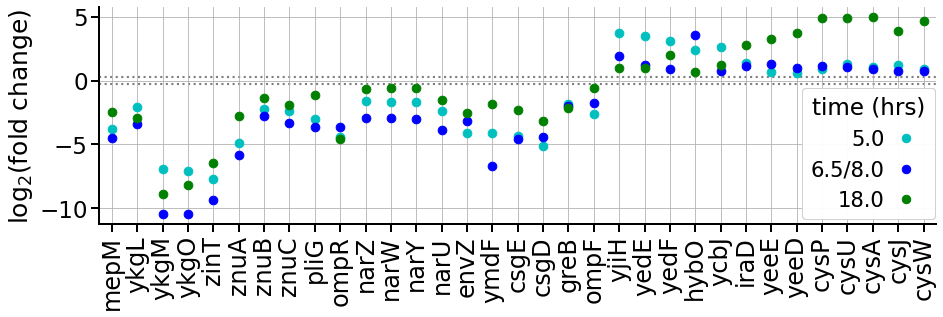

In [1410]:
### some DE analysis

savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 

plt.figure(figsize=(15,4))
plt.plot([0-0.5,len(circuit_markers)-0.5],[0.25,0.25],':',c='k',zorder=0,alpha=0.5,lw=2.1)
plt.plot([0-0.5,len(circuit_markers)-0.5],[-0.25,-0.25],':',c='k',zorder=0,alpha=0.5,lw=2.1)
plt.scatter(np.arange(len(circuit_markers)),de_circuit_early.sort_values(by='names').logfcs.tolist(),
            c='c',s=75)
plt.scatter(np.arange(len(circuit_markers)),de_circuit_mid.sort_values(by='names').logfcs.tolist(),
            c='b',s=75)
plt.scatter(np.arange(len(circuit_markers)),de_circuit_late.sort_values(by='names').logfcs.tolist(),
            c='g',s=75)
plt.xticks(np.arange(len(circuit_markers)),circuit_markers,rotation=90,fontsize=24)
plt.xlim(-0.5,len(circuit_markers)-0.5)
plt.grid('on')
# first legend
for ii in range(3):
    m1, = plt.plot([],[],'o',c=['c','b','g'][ii],label=['5.0','6.5/8.0','18.0'][ii])
leg1 = plt.legend(frameon=True,loc=(0.84,0.025),title='time (hrs)',markerscale=1.4,markerfirst=False,handletextpad=0,fontsize=21)
ax = plt.gca().add_artist(leg1)

# # # second and third legends
# m2, = plt.plot([],[],'o',c='darkgray',ms=4,label=r'$p > 0.05$')
# m3, = plt.plot([],[],'o',c='darkgray',ms=10,label=r'$p \leq 0.05$')
# plt.legend(handles=[m2,m3],loc=(1,0.0),frameon=False,markerfirst=True,handletextpad=0)

# plt.ylim(-0.5,len(circuit_markers)-0.5)
plt.ylabel(r'log$_2(\mathrm{fold \;change})$',fontsize=25)

if savefig: 
    plt.savefig(figDir+'fig3/dotplot_syn_markers.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

### Gene ontology analysis of biomarker genes

In [1309]:
go_biomarkers, _ = parse_go_json('GO_analysis_circuit_state_markers.json')

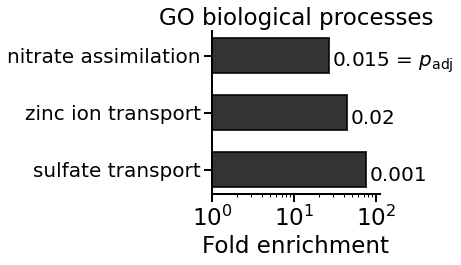

In [1321]:
savefig = False

plt.rcParams['ytick.minor.visible'] = False
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 

fig, ax = plt.subplots(figsize=(3,3))

# cmap = plt.cm.YlGn
# cmaplist = [cmap((i+1)*35) for i in range(cmap.N)]
# cmaplist = cmaplist[0:4]
# my_colors = [cmaplist[3],cmaplist[3],cmaplist[1],cmaplist[0],cmaplist[2],cmaplist[3]]
# cm = matplotlib.colors.LinearSegmentedColormap.from_list(
#         'test', cmaplist, N=4)

ylabels = go_biomarkers.biological_process.tolist()
ylabels[0] = 'sulfate transport'

plt.barh(ylabels,go_biomarkers.fold_enrichment,
        height=0.6,alpha=0.8,edgecolor='k',linewidth=2,
         color='k') 
plt.yticks(np.arange(0,len(ylabels)),ylabels,fontsize=20)
plt.xscale('log')
plt.xlim(1,110)
for ii, v in enumerate(go_biomarkers.fold_enrichment):
    if ii != len(go_biomarkers)-1: 
        ax.text(1.1*v, ii-0.2, f'{go_biomarkers.fdr[ii]:.0}',color='k',fontsize=20)
    else: 
        ax.text(1.1*v, ii-0.2, f'{go_biomarkers.fdr[ii]:.2} = '+r'$p_{\mathrm{adj}}$',color='k',fontsize=20)

# sm = ScalarMappable(cmap=cm,norm=plt.Normalize(3,max(go_biomarkers.ngenes.tolist())))
# sm.set_array([])

# cbar = plt.colorbar(sm,pad=0.3)
# cbar.set_label('count', rotation=90,labelpad=2,fontsize=20)

plt.title('GO biological processes',fontsize=23)
plt.xlabel('Fold enrichment',fontsize=23)
if savefig: 
    plt.savefig(figDir+'fig3/bar_GO_biomarkers.pdf',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

plt.rcParams['ytick.minor.visible'] = True

### Correlation between synthetic cell state genes and circuit genes

In [598]:
cdata = adata[adata.obs.strain.isin(['IcaR_Gate', 'NAND_Circuit', 'PhlF_Gate',
                                     'pBADmin','pTACmin'])].copy()

cdata = cdata[cdata.obs.timepoint.isin(['6.5'])].copy()

biomarker_corr_circuit = np.zeros((len(circuit_genes),len(circuit_markers)))
for ii, circuit_gene in enumerate(circuit_genes): 
    for jj, marker_gene in enumerate(circuit_markers): 
        rho, _ = sp.stats.pearsonr(cdata[:,circuit_gene].X.reshape(-1),cdata[:,marker_gene].X.reshape(-1))
        biomarker_corr_circuit[ii,jj] = rho

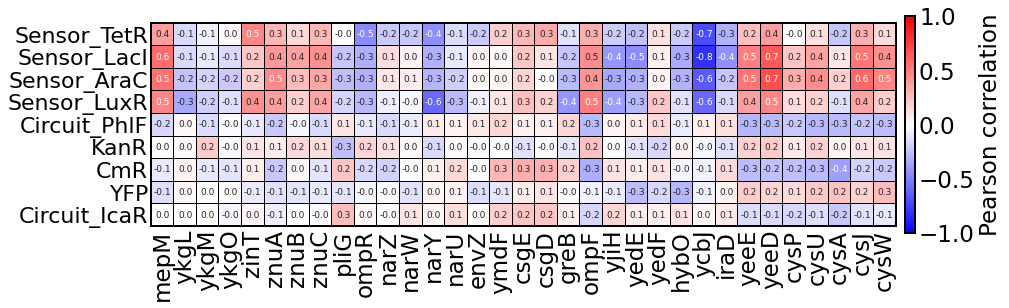

In [599]:
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True;
plt.rcParams['xtick.major.size'] = 0;
plt.rcParams['ytick.major.size'] = 0;

this_cmap = LinearSegmentedColormap.from_list(name='ybpcmap', colors=['blue','white','red'])

fig, ax = plt.subplots(figsize=(15,4.5))
hax = sns.heatmap(biomarker_corr_circuit,cmap=this_cmap,square=True,ax=ax,
            yticklabels=circuit_genes,xticklabels=circuit_markers,
                  vmin=-1,vmax=1,linewidths=0.005,linecolor='k',
            cbar_kws={'pad':0.01,'label':'Pearson correlation','shrink':1},annot=True,fmt='.1f',annot_kws={'fontsize':9}) #vmax=biomarker_corr_circuit.max(),vmin=biomarker_corr_circuit.min()
cbar_ax = fig.axes[-1] 
cbar_ax.set_frame_on(True)
for _, spine in hax.spines.items():
    spine.set_visible(True)
plt.xticks(np.arange(0,len(circuit_markers))+0.5,circuit_markers)
plt.yticks(np.arange(0,len(circuit_genes))+0.5,circuit_genes,fontsize=22)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/heatmap_biomarker_corr_circuit.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 
plt.rcParams['xtick.major.size'] = 8;
plt.rcParams['ytick.major.size'] = 8;

### Sigma factor, essential, and TF analysis of circuit marker genes

In [48]:
circuit_markers_ess = pd.DataFrame(essential_genes)[pd.DataFrame(essential_genes)[0].isin(circuit_markers)].values.reshape(-1).tolist()
circuit_markers_ess

['csgE', 'cysW', 'yedE']

In [49]:
tf_table = tf_gene_df[tf_gene_df.regulated.isin(circuit_markers)].sort_values(by='regulator')
print(tf_table.to_latex(index=False))

\begin{tabular}{lll}
\toprule
regulator & regulated & effect \\
\midrule
     ArcA &      hybO &      - \\
     BasR &      csgD &      + \\
     BasR &      csgE &      + \\
     CpxR &      ompF &      - \\
     CpxR &      csgE &      - \\
     CpxR &      csgD &      - \\
      Cra &      csgE &      + \\
      Cra &      csgD &      + \\
     CsgD &      csgD &      + \\
     CsgD &      csgE &      + \\
     CysB &      cysW &      + \\
     CysB &      cysU &      + \\
     CysB &      cysA &      + \\
     CysB &      cysJ &      + \\
     CysB &      cysP &      + \\
     EnvY &      ompF &      + \\
     FliZ &      csgE &      - \\
     FliZ &      csgD &      - \\
      Fur &      ompF &      + \\
      Fur &      zinT &      + \\
     MlrA &      csgD &      + \\
     MlrA &      csgE &      + \\
     MqsA &      csgD &      - \\
     MqsA &      csgE &      - \\
     NarL &      hybO &      - \\
     OmpR &      csgD &      + \\
     OmpR &      csgE &      + \\
     OmpR

In [50]:
# sigma24 - rpoE
# sigma38 - rpoS
# sigma70 - rpoD
sigma_table = sigma_gene_df[sigma_gene_df.regulated.isin(circuit_markers)].sort_values(by='regulator')
print(sigma_table.to_latex(index=False))


\begin{tabular}{lll}
\toprule
regulator & regulated & effect \\
\midrule
  Sigma24 &      narW &      + \\
  Sigma38 &      csgD &      + \\
  Sigma38 &      csgE &      + \\
  Sigma38 &      iraD &      + \\
  Sigma38 &      narU &      + \\
  Sigma38 &      ompF &      + \\
  Sigma38 &      znuA &      + \\
  Sigma70 &      zinT &      + \\
  Sigma70 &      ykgO &      + \\
  Sigma70 &      ykgM &      + \\
  Sigma70 &      ompR &      + \\
  Sigma70 &      ompF &      + \\
  Sigma70 &      narU &      + \\
  Sigma70 &      iraD &      + \\
  Sigma70 &      hybO &      + \\
  Sigma70 &      cysU &      + \\
  Sigma70 &      cysW &      + \\
  Sigma70 &      znuB &      + \\
  Sigma70 &      cysP &      + \\
  Sigma70 &      cysJ &      + \\
  Sigma70 &      cysA &      + \\
  Sigma70 &      csgE &      + \\
  Sigma70 &      csgD &      + \\
  Sigma70 &      envZ &      + \\
  Sigma70 &      znuC &      + \\
\bottomrule
\end{tabular}



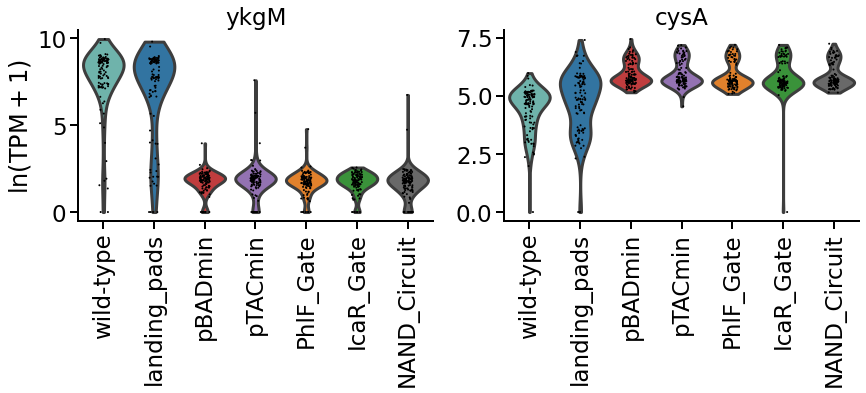

In [52]:
# group by strain and plot 
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 

fig, ax = plt.subplots(1,2,figsize=(14,3.5))
this_gene = 'ykgM'
this_ax = sc.pl.violin(adata,keys=[this_gene],groupby='strain',
             rotation=90,ax=ax[0],size=2,
             palette=strain_palette, show=False) 
this_ax.set_ylabel(r'$\mathrm{ln}(\mathrm{TPM} + 1)$',fontsize=24)
this_ax.set_title(this_gene,fontsize=23)
this_gene='cysA'
this_ax = sc.pl.violin(adata,keys=[this_gene],groupby='strain',
             rotation=90,ax=ax[1],size=2,
             palette=strain_palette, show=False) 
this_ax.set_ylabel(None)
this_ax.set_title(this_gene,fontsize=23)

if savefig: 
    plt.savefig(figDir+'supplementalFigs/violin_highlowfc_group_strain.pdf',bbox_inches='tight',transparent=True,dpi=300)

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

Say we subset the data to only the TFs above, can we distinguish strains in an unsupervised way?

In [53]:
tfs = [s[0].lower() + s[1:] for s in tf_table.regulator.unique().tolist()]
tf_data = bdata[:,tfs].copy()
sc.pp.pca(tf_data,n_comps=10,random_state=0)

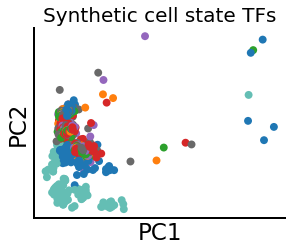

In [55]:
savefig = False
fig, ax = plt.subplots(figsize=(4.5,3.5))
this_ax = sc.pl.pca(tf_data,color='strain',size=250,palette=strain_palette,show=False,ax=ax)
this_ax.set_title('Synthetic cell state TFs',fontsize=20)
this_ax.legend([],frameon=False)
if savefig: 
    plt.savefig(figDir+'fig3/pc_tfs_group_strain.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [476]:
# do they separate with random TFs
rand_tfs = choices(list(set(TFs) - set(tfs)),k=20) # don't choose from TFs involved in synthetic cell state gene regulation
tf_data = bdata[:,rand_tfs].copy()
sc.pp.pca(tf_data,n_comps=10,random_state=0)

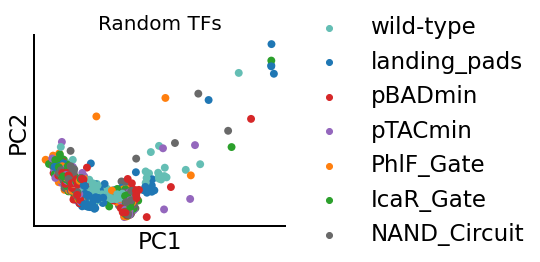

In [478]:
savefig = False
fig, ax = plt.subplots(figsize=(4.5,3.5))
this_ax = sc.pl.pca(tf_data,color='strain',size=250,palette=strain_palette,show=False,ax=ax)
this_ax.set_title('Random TFs',fontsize=20)
if savefig: 
    plt.savefig(figDir+'fig3/pc_randtfs_group_strain.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

### Zoom in on mepM

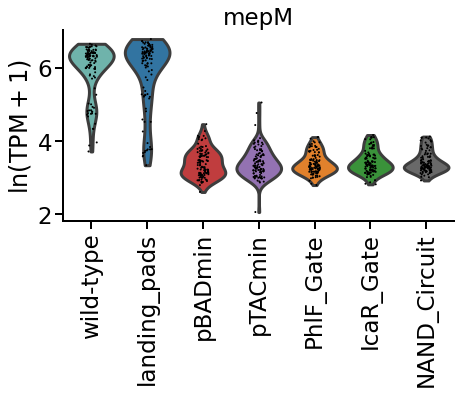

In [77]:
# group by strain and plot mepM
savefig = False
plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
fig, ax = plt.subplots(figsize=(7,3.5))
this_ax = sc.pl.violin(adata[adata[:,'mepM'].X.toarray() >= 0.01].copy(),keys=['mepM'],groupby='strain',
             rotation=90,cut=0,ax=ax,size=2,
             palette=strain_palette, show=False) 

this_ax.set_ylabel(r'$\mathrm{ln}(\mathrm{TPM} + 1)$',fontsize=24)
this_ax.set_title('mepM',fontsize=23)

if savefig: 
    plt.savefig(figDir+'fig4/violin_mepM_group_strain.pdf',bbox_inches='tight',transparent=True,dpi=300)

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

### Ceroni et al (20XX) and Borujeni et al (20XX) explore the role of htpG, ibpAB, dnaKJ for their dysregulation under circuit burden

In [79]:
sc.pl.umap(bdata,color='strain',
           palette=[[100/255, 190/255, 180/255],
                'tab:blue','tab:red','tab:purple','tab:orange','tab:green','dimgray'],
           size=150,add_outline=True,show=False)
# strangely, have to run this to set the colors for the groupby in the heatmap below
plt.close()

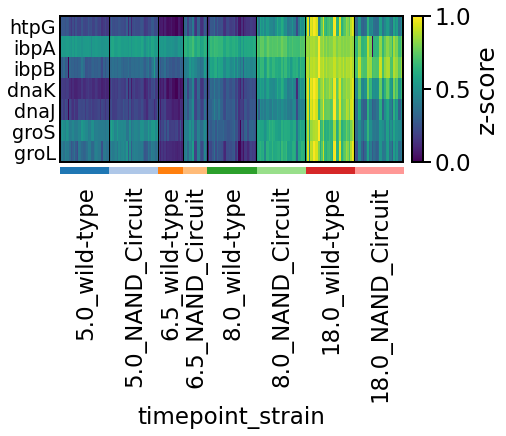

In [80]:
# downregulated biomarker genes
savefig = False

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True; 

ceroni_markers = ['htpG','ibpA','ibpB','dnaK','dnaJ','groS','groL']

this_ax = sc.pl.heatmap(bdata[bdata.obs.strain.isin(['wild-type','NAND_Circuit'])].copy(), var_names=ceroni_markers, 
              groupby=['timepoint','strain'],
              swap_axes=True,figsize=(6.5,3),
              cmap='viridis',standard_scale='var',
              show=False) # ,save='_circuit_state_biomarkers_down.pdf'
# this_ax['groupby_ax'].set_xlabel('')
this_ax['groupby_ax'].set_xticklabels(this_ax['groupby_ax'].get_xticklabels(),fontsize=23)

fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel('z-score',fontsize=25)
if savefig: 
    plt.savefig(figDir+'fig2/heatmap_ceroni_markers.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 

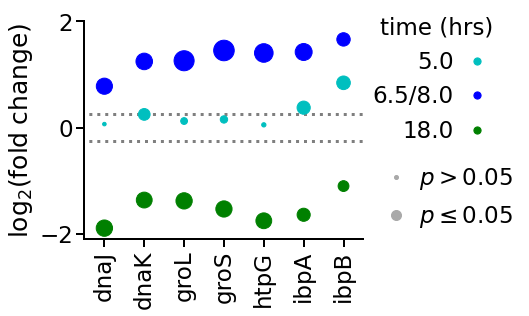

In [1299]:
savefig = False
plt.figure(figsize=(5,4))
plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.scatter(range(7),de_ceroni_early.sort_values(by='names').logfcs.tolist(),c='c',
            s=(30*de_ceroni_early.sort_values(by='names').fdr).tolist())
plt.scatter(range(7),de_ceroni_mid.sort_values(by='names').logfcs.tolist(),c='b',
            s=(30*de_ceroni_mid.sort_values(by='names').fdr).tolist())
plt.scatter(range(7),de_ceroni_late.sort_values(by='names').logfcs.tolist(),c='g',
            s=(30*de_ceroni_late.sort_values(by='names').fdr).tolist())
plt.plot([-1,8],[0.25,0.25],':',c='k',zorder=0,alpha=0.5)
plt.plot([-1,8],[-0.25,-0.25],':',c='k',zorder=0,alpha=0.5)
plt.xticks(range(7),de_ceroni_early.sort_values(by='names').names.tolist(),rotation=90)
plt.xlim(-0.5,6.5)

# first legend
for ii in range(3):
    m1, = plt.plot([],[],'o',c=['c','b','g'][ii],label=['5.0','6.5/8.0','18.0'][ii])
leg1 = plt.legend(frameon=False,loc=(1,0.4),title='time (hrs)',markerscale=1.2,markerfirst=False,handletextpad=0)
ax = plt.gca().add_artist(leg1)

# # second and third legends
m2, = plt.plot([],[],'o',c='darkgray',ms=4,label=r'$p > 0.05$')
m3, = plt.plot([],[],'o',c='darkgray',ms=10,label=r'$p \leq 0.05$')
plt.legend(handles=[m2,m3],loc=(1,0.0),frameon=False,markerfirst=True,handletextpad=0)

plt.ylim(-2.1,2)
plt.ylabel(r'log$_2(\mathrm{fold \;change})$',fontsize=25)

if savefig: 
    plt.savefig(figDir+'fig2/dotplot_ceroni_markers.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

### DEGs only at one timepoint

In [333]:
set(de_genes_early) - set(de_genes_mid) - set(de_genes_late)

{'acnA',
 'actP',
 'aegA',
 'agaS',
 'amiA',
 'amiC',
 'ampH',
 'amtB',
 'ansB',
 'aphA',
 'arnF',
 'aroF',
 'aroL',
 'aroP',
 'asnA',
 'asnS',
 'astE',
 'bamD',
 'bcp',
 'bfr',
 'bioD',
 'btuE',
 'caiA',
 'caiB',
 'caiE',
 'ccmA',
 'cheB',
 'chiP',
 'citE',
 'cmoA',
 'cmtB',
 'cobS',
 'codA',
 'cptA',
 'crfC',
 'dacA',
 'dctA',
 'ddpC',
 'dhaK',
 'dhaL',
 'dusA',
 'efeO',
 'emrD',
 'emrY',
 'emtA',
 'entB',
 'entC',
 'entE',
 'entF',
 'entH',
 'entS',
 'exbD',
 'fadH',
 'fadL',
 'fdhF',
 'fdnG',
 'fecE',
 'fepA',
 'fepB',
 'fepE',
 'fes',
 'fhuE',
 'fimA',
 'fimC',
 'fimD',
 'fimH',
 'fimI',
 'fkpA',
 'flgA',
 'flgB',
 'flgC',
 'flgD',
 'flgE',
 'flgF',
 'flgG',
 'flgH',
 'flgI',
 'flgJ',
 'flgK',
 'flgL',
 'flhA',
 'flhB',
 'flhD',
 'flhE',
 'fliA',
 'fliC',
 'fliE',
 'fliF',
 'fliG',
 'fliH',
 'fliI',
 'fliK',
 'fliL',
 'fliN',
 'fliO',
 'fliP',
 'fliQ',
 'fliS',
 'fliZ',
 'fnr',
 'folE',
 'frc',
 'frdD',
 'fsaB',
 'fucA',
 'fucO',
 'fumB',
 'ghoS',
 'ghoT',
 'glyA',
 'gntT',
 'gpmA

In [509]:
go_18hr

,biological_process,ngenes,gene_set,fold_enrichment,fdr
0,hydrogen sulfide biosynthetic process,6,"[cysI, cysJ, cysH, cysC, cysD, cysN]",14.837838,0.042066
1,glyoxylate cycle,6,"[iclR, aceB, aceA, aceK, icd, acnB]",11.128378,0.046003
2,tricarboxylic acid cycle,15,"[gltA, aceK, icd, aspA, aceB, aceA, sucC, sucD...",7.674744,0.000097
3,alpha-amino acid metabolic process,30,"[ilvD, cysK, cysI, leuL, cysJ, ilvE, puuA, gad...",2.248157,0.050000


In [346]:
go_6and8hr

,biological_process,ngenes,gene_set,fold_enrichment,fdr
0,slime layer polysaccharide biosynthetic process,9,"[wcaL, wcaK, wcaI, wcaF, wcaE, wcaD, wcaC, wca...",5.812941,0.037756
1,hexitol metabolic process,9,"[gatZ, uxaB, gatA, uxuB, gatB, gatD, mtlD, yei...",5.284492,0.046223
2,colanic acid biosynthetic process,15,"[wzc, wcaJ, wcaI, galE, wcaG, wcaF, wcaE, cpsB...",5.099071,0.004894
3,reactive nitrogen species metabolic process,14,"[narV, narU, narZ, narY, narX, hmp, narW, norW...",3.767647,0.035845
4,neutral amino acid transport,18,"[livK, alaE, livJ, sdaC, livM, gltL, glnH, rht...",3.321681,0.024839
5,cellular respiration,37,"[hybB, hybA, dcuB, gltA, hybC, aceK, cyoA, yjj...",2.096285,0.036012
6,cellular amino acid biosynthetic process,42,"[hisB, ilvC, hisC, hisD, leuL, argD, cysJ, met...",1.883824,0.047275
7,anion transport,53,"[dcuB, nikA, dcuC, cysA, chaA, glnH, cadB, arg...",1.773667,0.042935
8,alpha-amino acid metabolic process,54,"[leuL, argD, cysJ, puuA, gadA, gadB, glnA, yib...",1.761497,0.039479
9,transmembrane transport,131,"[ompF, csgE, yhhQ, csgF, dcuB, yhhS, nikA, dcu...",1.419641,0.025266


In [424]:
go_5hr

,biological_process,ngenes,gene_set,fold_enrichment,fdr
0,bacterial-type flagellum assembly,15,"[flhA, flhB, flgA, flhD, fliG, fliI, fliK, frd...",4.784314,4.044223e-03
1,nitrate assimilation,16,"[narQ, narP, narV, narU, narZ, narY, narW, nrf...",4.592941,3.434190e-03
2,colanic acid biosynthetic process,14,"[wzc, wcaJ, wcaI, wcaG, wcaF, wcaE, cpsB, manA...",4.230341,1.254160e-02
3,aromatic amino acid family biosynthetic process,15,"[tyrA, aroL, tyrB, aroG, trpD, trpE, aroF, trp...",3.312217,3.873706e-02
4,anaerobic respiration,34,"[hybB, hybA, dcuB, hybC, yjjI, ynfE, hybO, acn...",3.200000,1.683109e-04
5,bacterial-type flagellum-dependent cell motility,27,"[frdA, frdB, frdC, flgA, fliC, flgB, fliD, flg...",3.100235,2.886293e-03
6,establishment of protein localization,36,"[csgE, oppC, oppD, csgF, oppF, oppA, oppB, yid...",2.222391,1.315219e-02
7,alpha-amino acid metabolic process,60,"[cysK, hemA, cysI, dsdA, cysJ, puuA, hemF, yib...",1.739750,1.900829e-02
8,transport,167,"[ompF, csgE, csgF, dcuB, chiP, nikA, dcuC, yeb...",1.346596,1.939475e-02
9,UNCLASSIFIED,87,"[yjdM, yibN, ygbE, ycbJ, ygfF, yebE, ybhB, yea...",0.507604,4.622506e-10


In [1059]:
set.intersection(set(de_genes_mid) - set(de_genes_early) - set(de_genes_late), set(go_6and8hr.gene_set[6]) )

{'alaA',
 'argD',
 'argI',
 'dadX',
 'hisB',
 'hisC',
 'hisD',
 'hisF',
 'hisG',
 'hisH',
 'hisI',
 'lysA',
 'metB',
 'metL',
 'putA'}

In [511]:
set.intersection(set(de_genes_late) - set(de_genes_early) - set(de_genes_mid), set(go_18hr.gene_set[2]) )

{'icd'}

### Which genes are differentially expressed at all timepoints

In [1150]:
de_genes = list(set.intersection(set(de_genes_early), set(de_genes_mid), set(de_genes_late)))

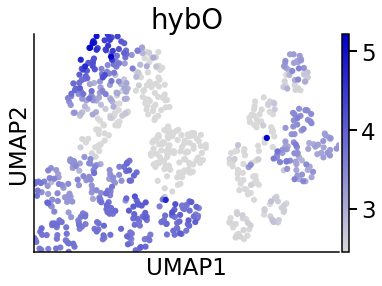

In [1314]:
plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 

name = 'hybO' # 'putA' # 'modB' 
fig, ax = plt.subplots()
sc.pl.umap(bdata,color=name,cmap=cmap,vmin=0.85*bdata[:,name].X.mean(axis=0)
           ,ax=ax) 

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 


### Which genes correlate best with YFP expression?
Or other interesting genes

In [1241]:
# which genes are correlated with a gene of interest: this_gene
this_gene = 'ompR'
tpm_df = pd.DataFrame(adata.X,columns=adata.var_names.tolist())
corr_ = np.array(tpm_df.corrwith(tpm_df[this_gene]))

corr_cutoff = 0.7
corr_genes = list(adata.var_names[np.where(np.abs(corr_) >= corr_cutoff)[0]]) 
# want this_gene to come first in list
corr_genes = [this_gene] + corr_genes
corr_genes = list(dict.fromkeys(corr_genes)) 

# make a correlation heatmap with just these genes
corr_ = tpm_df[corr_genes].corr()

# sort by descending correlation
corr_genes = corr_.sort_values(by=[this_gene],ascending=False)[this_gene].index.tolist()

In [1244]:
corr_genes

['ompR',
 'rsd',
 'fecA',
 'envZ',
 'dtpA',
 'csgD',
 'greB',
 'ymdF',
 'narZ',
 'rsd_2',
 'fecA_2',
 'Sensor_AraC',
 'Sensor_LacI']

<AxesSubplot:>

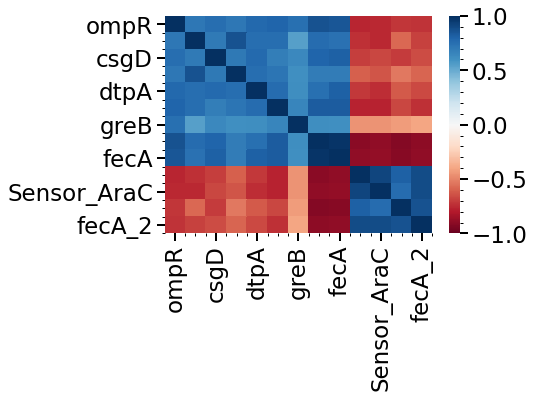

In [1243]:
sns.heatmap(corr_,cmap='RdBu',center=0,vmin=-1,vmax=1)

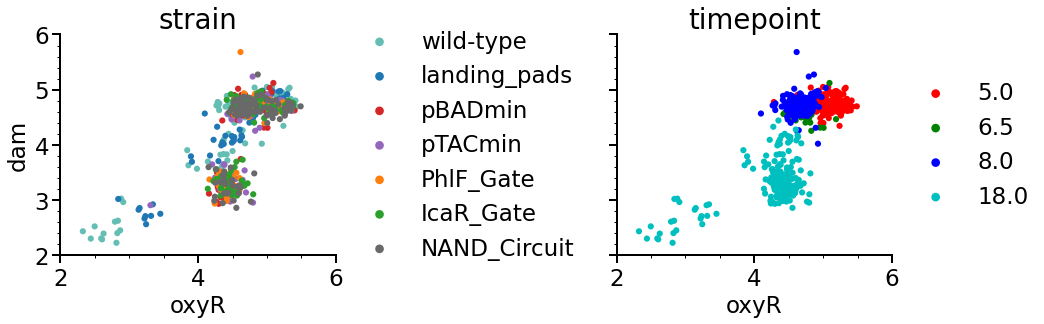

In [344]:
savefig = False

xgene = 'oxyR'
ygene = 'dam'
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
sc.pl.scatter(adata,x=xgene,y=ygene,color='strain',palette=strain_palette,show=False, ax=ax[0])
sc.pl.scatter(adata,x=xgene,y=ygene,color='timepoint',palette=['r','g','b','c'],show=False,ax=ax[1])
ax[0].set_xlim(2,6)
ax[0].set_ylim(2,6)
ax[1].set_ylabel(None)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/scatter_oxyR_dam.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

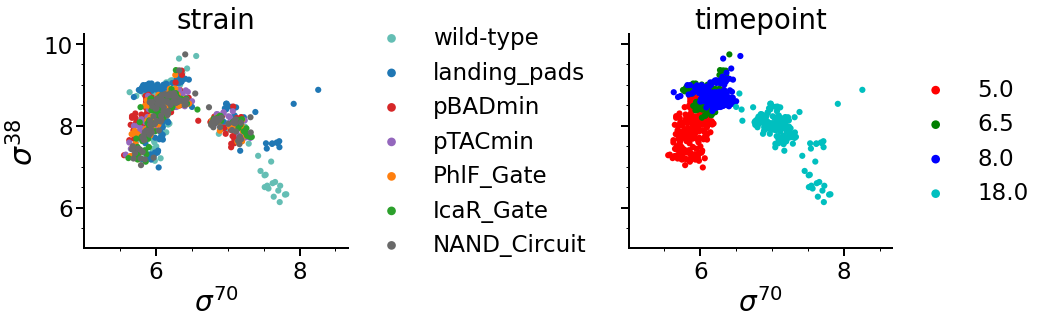

In [358]:
savefig = False

xgene = 'rpoD'
ygene = 'rpoS'
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
sc.pl.scatter(adata,x=xgene,y=ygene,color='strain',palette=strain_palette,show=False, ax=ax[0])
sc.pl.scatter(adata,x=xgene,y=ygene,color='timepoint',palette=['r','g','b','c'],show=False,ax=ax[1])
ax[0].set_xlabel('$\sigma^{70}$', fontsize=28)
ax[1].set_xlabel('$\sigma^{70}$', fontsize=28)
ax[0].set_ylabel('$\sigma^{38}$', fontsize=30)
ax[0].set_xlim(5)
ax[0].set_ylim(5)
ax[1].set_ylabel(None)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/scatter_sig70_sig38.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

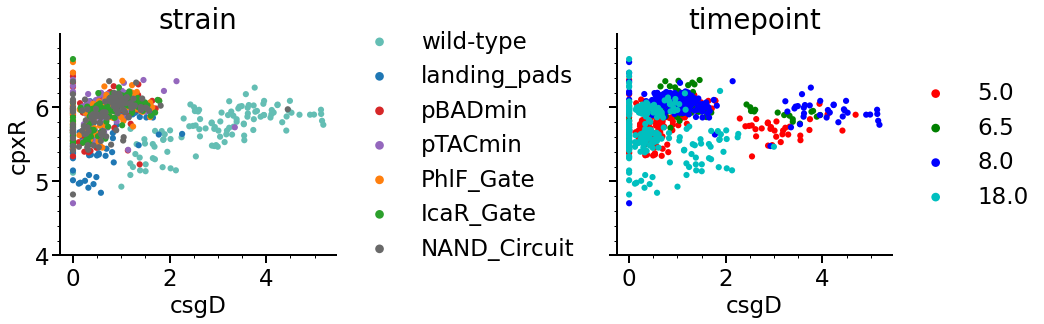

In [362]:
savefig = False

xgene = 'csgD'
ygene = 'cpxR'
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
sc.pl.scatter(adata,x=xgene,y=ygene,color='strain',palette=strain_palette,show=False, ax=ax[0])
sc.pl.scatter(adata,x=xgene,y=ygene,color='timepoint',palette=['r','g','b','c'],show=False,ax=ax[1])
# ax[0].set_xlim(5)
ax[0].set_ylim(4)
ax[1].set_ylabel(None)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/scatter_sig70_sig38.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

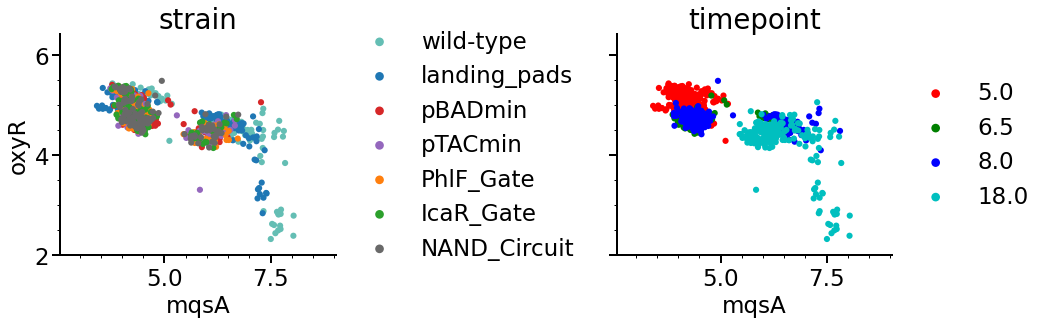

In [378]:
savefig = False

xgene = 'mqsA'
ygene = 'oxyR'
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
sc.pl.scatter(adata,x=xgene,y=ygene,color='strain',palette=strain_palette,show=False, ax=ax[0])
sc.pl.scatter(adata,x=xgene,y=ygene,color='timepoint',palette=['r','g','b','c'],show=False,ax=ax[1])
ax[0].set_xlim(2.55)
ax[0].set_ylim(2)
ax[1].set_ylabel(None)
plt.tight_layout()
if savefig: 
    plt.savefig(figDir+'supplementalFigs/scatter_sig70_sig38.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

In [25]:
def plot_ts(this_gene,this_ylim=0.0):
    fig, ax = plt.subplots(2,4,figsize=(16,8),sharex=True,sharey=True)
#     fig.delaxes(ax[-1,-1])
    ax = ax.reshape(-1)
    plt.suptitle(this_gene)
    for ii, strain in enumerate(strain_order_list):
        gene_ts = []
        for time in adata.obs.timepoint.unique():
            sub_obs = (adata.obs.timepoint.isin([time])) & (adata.obs.strain.isin([strain]))
            yplot = np.exp(adata[sub_obs,this_gene].X.reshape(-1).toarray()).tolist()
            gene_ts.append(yplot)
        gene_df = pd.DataFrame({'5.0': pd.Series(gene_ts[0]), '6.5': pd.Series(gene_ts[1]), '8.0': pd.Series(gene_ts[2]), '18.0': pd.Series(gene_ts[3])})
        ax[ii].set_title(strain)
        sns.lineplot(data=gene_df.median(axis=0),ax=ax[ii],color='k')
        sns.stripplot(data=gene_df,ax=ax[ii],palette=['r','g','b','c'])
        sns.lineplot(data=gene_df.median(axis=0),ax=ax[-1],color=strain_palette[ii])
    ax[0].set_ylim(this_ylim,)
    plt.show()

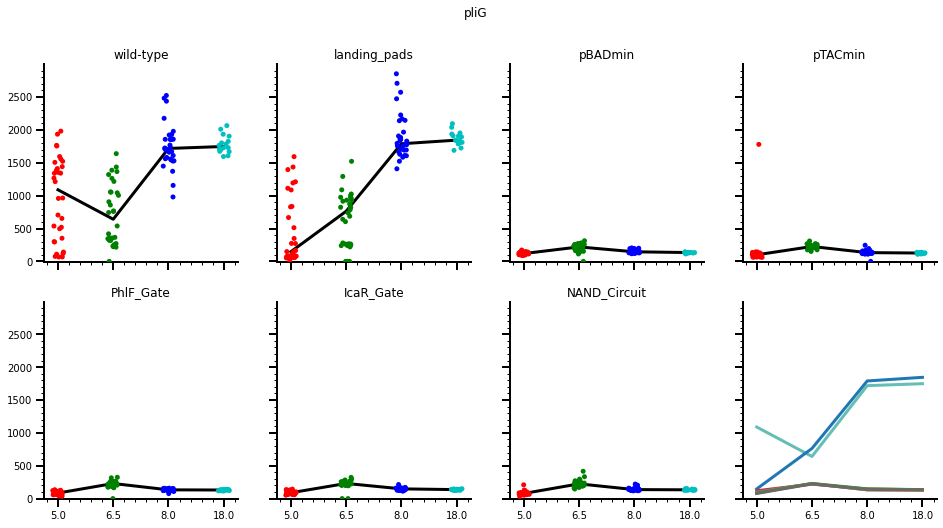

In [26]:
plot_ts('pliG',this_ylim=-10)

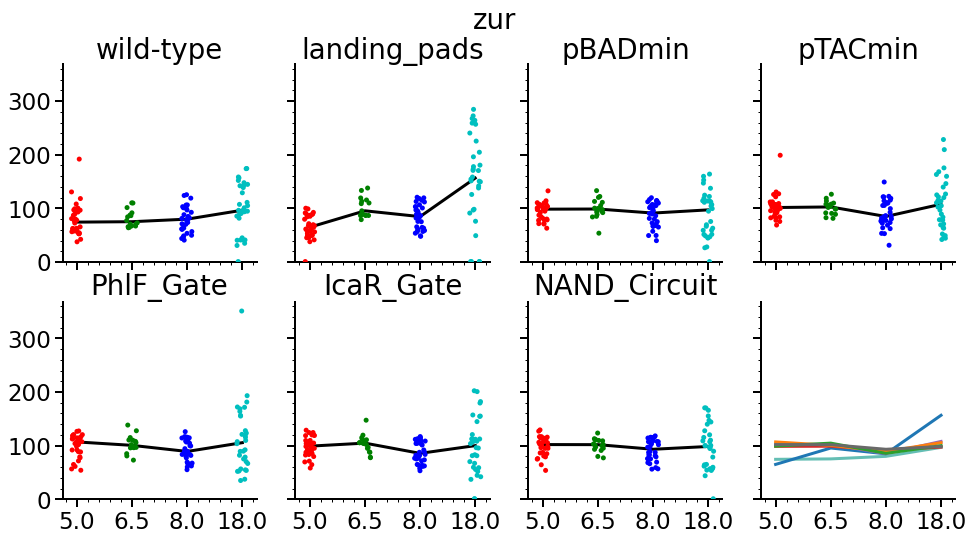

In [735]:
plot_ts('zur',this_ylim=0.0) # zur represses ykgM

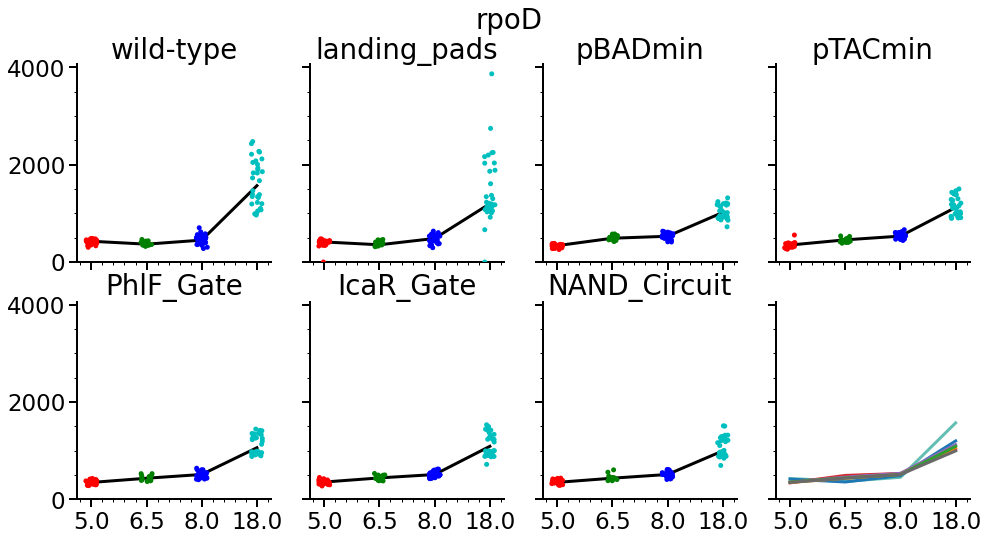

In [736]:
plot_ts('rpoD',this_ylim=0.0) # rpoD activates ykgM